- ÏõêÎ≥∏ÏûÑ.
- Î≥¥Í∞Ñ Ïù¥ÌõÑ 30Ïùº Ï†ïÏ†ú

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ads_year = pd.read_csv("df_rpt_clean.csv")
ads_list = pd.read_csv("df_list_v1.csv")


/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_43043/3084689073.py:2: DtypeWarning: Columns (12,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  ads_list = pd.read_csv("df_list_v1.csv")


In [3]:
is_test_ad = ads_list["ads_name"].str.contains("ÌÖåÏä§Ìä∏|ÏÑúÎπÑÏä§Ï¢ÖÎ£å|ÏÇ≠Ï†ú", na=False, case=False)
is_valid_test_ad = ads_list["ads_name"].str.contains("Î∏åÎ†àÏù∏ ÌÖåÏä§Ìä∏|Í≤åÏûÑÌÖåÏä§Ìä∏", na=False, case=False)
condition_to_delete = is_test_ad & ~is_valid_test_ad
ads_list = ads_list[~condition_to_delete].copy()

In [4]:
# --- Î∂ÑÎ•ò Ìï®Ïàò (Ï†úÏô∏ ÌÇ§ÏõåÎìú Ï†ÅÏö©) ---

def categorize_domain(df, domain_name, keywords, search_cols, exclude_keywords=None):
    """
    DataFrameÏùò ÏßÄÏ†ïÎêú Ïó¥(search_cols)ÏóêÏÑú ÌÇ§ÏõåÎìúÎ•º Ï∞æÏïÑ 
    ÏÉàÎ°úÏö¥ ÎèÑÎ©îÏù∏ÏùÑ Î∂ÄÏó¨ÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§. (Ï†úÏô∏ ÌÇ§ÏõåÎìú Ï†ÅÏö©)
    
    Args:
        df (pd.DataFrame): ÏûëÏóÖÌï† Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
        domain_name (str): ÏÉàÎ°ú Î∂ÄÏó¨Ìï† ÎèÑÎ©îÏù∏ Ïù¥Î¶Ñ (Ïòà: 'Í∏àÏúµ/Î≥¥Ìóò')
        keywords (list): Ï∞æÏùÑ ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏ (Ïòà: ['ÌîºÏã±', 'Î≥¥Ìóò'])
        search_cols (list): ÌÇ§ÏõåÎìúÎ•º Í≤ÄÏÉâÌï† Ïó¥ Ïù¥Î¶Ñ Î¶¨Ïä§Ìä∏ (Ïòà: ['ads_name', 'ads_summary'])
        exclude_keywords (list, optional): Ï†úÏô∏Ìï† ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏ (Ïòà: ['Í≥†ÏñëÏù¥'])
        
    Returns:
        pd.DataFrame: ÎèÑÎ©îÏù∏Ïù¥ Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
    """
    # 1. ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏Î•º OR(|) Ï°∞Í±¥ÏúºÎ°ú Î¨∂Ïñ¥ ÌïòÎÇòÏùò Í≤ÄÏÉâ Ìå®ÌÑ¥ÏúºÎ°ú ÎßåÎì≠ÎãàÎã§.
    keyword_pattern = '|'.join(keywords)
    
    # 2. Í≤ÄÏÉâÌï† Î™®Îì† Ïó¥ÏùÑ ÎåÄÏÉÅÏúºÎ°ú ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®ÎêòÏóàÎäîÏßÄ ÌôïÏù∏ÌïòÎäî Ï†ÑÏ≤¥ Ï°∞Í±¥ÏùÑ ÎßåÎì≠ÎãàÎã§.
    contains_keyword = df[search_cols].apply(
        lambda col: col.str.contains(keyword_pattern, na=False)
    ).any(axis=1)
    
    # 3. Ï†úÏô∏ ÌÇ§ÏõåÎìúÍ∞Ä ÏûàÏùÑ Í≤ΩÏö∞, Ï†úÏô∏ ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®Îêú ÌñâÏùÑ FalseÎ°ú Ï≤òÎ¶¨
    if exclude_keywords is not None and len(exclude_keywords) > 0:
        exclude_pattern = '|'.join(exclude_keywords)
        contains_exclude = df[search_cols].apply(
            lambda col: col.str.contains(exclude_pattern, na=False)
        ).any(axis=1)
    else:
        contains_exclude = pd.Series([False]*len(df), index=df.index)
    
    # 4. 'domain' Ïó¥Ïù¥ ÎπÑÏñ¥ÏûàÎäî(NaN) Ìñâ Ï§ëÏóêÏÑú, ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®ÎêòÍ≥†, Ï†úÏô∏ ÌÇ§ÏõåÎìúÎäî Ìè¨Ìï®ÎêòÏßÄ ÏïäÏùÄ ÌñâÎßå ÏÑ†ÌÉù
    condition = (df['domain'].isna()) & (contains_keyword) & (~contains_exclude)
    
    # 5. Ìï¥Îãπ ÌñâÏùò 'domain' Ïó¥Ïóê ÏÉàÎ°úÏö¥ ÎèÑÎ©îÏù∏ Ïù¥Î¶ÑÏùÑ Ï±ÑÏõå ÎÑ£ÏäµÎãàÎã§.
    df = df.copy()  # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î≥¥Ìò∏
    df.loc[condition, 'domain'] = domain_name
    
    print(f"‚úÖ '{domain_name}' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! ({condition.sum()}Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: {exclude_keywords})")
    return df

# --- Ìï®Ïàò ÏÇ¨Ïö© ÏòàÏãú ---

# 0. Î®ºÏ†Ä 'domain' Ïó¥ÏùÑ ÏÉùÏÑ±ÌïòÍ≥† NaNÏúºÎ°ú Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
ads_list['domain'] = np.nan

# 1. 'Í∏àÏúµ/Î≥¥Ìóò' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ (Ï†úÏô∏ ÌÇ§ÏõåÎìú: 'Í≥†ÏñëÏù¥')
keywords_finance = ['Í∏àÏúµ','ÌîºÏã±', 'Î≥¥Ìóò', 'Ï£ºÏãù', 'ÌéÄÎìú', 'Ïä§ÌÉÅ', 'Ïã†Ìïú', 'Î®∏ÎãàÌä∏Î¶¨Ïπ¥Îìú', 'Í≥µÎ™®Ï£º', 'KB', 'ÏóÖÎπÑÌä∏', 'Í±∞ÎûòÏÜå', 'ÌôòÍ∏âÍ∏à', 'ÏÉÅÏ°∞','ÎçîÌïÄ','Ï¶ùÍ∂å','Î±ÖÌÅ¨','Î≥¥ÌóòÎ£å']
exclude_keywords_finance = ['Í≥†ÏñëÏù¥','Ï∞®Ï∞®Ï∞®','Ï§ëÍ≥†Ï∞®','Idle']
search_columns = ['ads_name', 'ads_save_way']
ads_list = categorize_domain(ads_list, 'Í∏àÏúµ/Î≥¥Ìóò', keywords_finance, search_columns, exclude_keywords=exclude_keywords_finance)


# 2. 'Í≤åÏûÑ' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_game = [
    'Í≤åÏûÑ', 'Ïä§ÏΩîÏñ¥', 'Ï∫êÎ¶≠ÌÑ∞', 'ÏÑúÎ∏åÌÄòÏä§Ìä∏', 'Ìè¨Ïª§', 'ÌçºÏ¶ê', 'ÎùºÏä§Ìä∏Ïõå', 'ÌîºÏûê Î†àÎîî', 
    'Î≥µÍ∂å', 'RAID', 'Î®∏ÏßÄÏïÑÏùºÎûúÎçîÏä§', 'ÌÇ§Ïö∞Í∏∞', 'Merge', 'Puzzle', 'ÏïÑÏºÄÎ°†', 'Îã§ÌÅ¨ÏóîÏ†§',
    'ÏïÖÎßàÎã®', 'RPG', 'ÏÑúÎ∞îÏù¥Î≤å', 'ÎùºÎ∞î', 'Î™®Î∞îÏùº', 'ÏÇ¨Ï†ÑÏòàÏïΩ', 'ÌÉÄÏù¥ÎãàÌåú', 'Ïù¥Í≥ÑÎ∞•', 'ÌÉÄÏù¥Ïø§',
    'Í∞ïÏ•ê','2X','Í≥®Î™©Ï£ºÎ∞©', 'Ïò¨Î∞îÎ•∏Í≥†','Ï≤†Î¨ºÌååÌÅ¨','Î†àÎ≤®','ÎèÑÎã¨','Îã¨ÏÑ±','00Ï†ê','ÏõêÏä§ÌÜ†Ïñ¥','Idle','Lv.',
    'Ï¥àÏù¥Ïä§ ÎßûÏ∂îÍ∏∞','ÌÅ¥Î¶¨Ïñ¥','ÏóêÎ¶¨Ïñ¥','ÎπóÏç∏','Complete','Tycoon','Îã§Ïù¥ÎÖ∏ Ìà¨ Î†àÏù¥Ïä§','ÌöçÎìù',
    'Íµ¨Ïó≠ Ìï¥Ï†ú','Î™®ÏúºÍ∏∞','ÏÜåÏö∏ Î°úÍ∑∏','Ïû†Í∏à Ìï¥Ï†ú','Ïô∏Í≥Ñ ÏãúÎåÄ','Ï¢ÄÎπÑ','Î∂âÏùÄ ÎèÑÏãú', 'ÏΩîÏù∏ÌîºÌÅ¥', 'ÎîîÌéúÏä§', 'ÎîîÎ∞îÏù∏Ïó£ÏßÄ','ÏòÅÏõÖÏ§çÏ§ç','KÎç∞Î™¨ÌóåÌÑ∞Ïä§','Ï°∞Ï°∞Ïùò Íøà','Ìé∏ÏùòÏ†ê Ï†ïÎ¶¨Ïôï 3D'
]
# Ï†úÏô∏Ìï† ÌÇ§ÏõåÎìú Î¶¨Ïä§Ìä∏Î•º Ï†ïÏùòÌï©ÎãàÎã§.
exclude_keywords_game = ['ÌîÑÎ¶¨Îã§Ïù¥Îπô']

# Ìï®ÏàòÎ•º Ìò∏Ï∂úÌï† Îïå exclude_keywords Ïù∏ÏûêÎ•º Ï†ïÌôïÌûà Ï†ÑÎã¨Ìï©ÎãàÎã§.
ads_list = categorize_domain(
    ads_list, 
    'Í≤åÏûÑ', 
    keywords_game, 
    search_columns, 
    exclude_keywords=exclude_keywords_game
)


# 3-1. 'ÏÉùÌôú/ÏáºÌïë/Ïù¥Ïª§Î®∏Ïä§_ÏÉÅÌíàÏÜåÎπÑ' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_goods_consumption = [
    # Í∏∞Ï°¥ ÌÇ§ÏõåÎìú Ïú†ÏßÄ (ÏÇ≠Ï†ú/ÏàòÏ†ï Í∏àÏßÄ)
    # ÏãùÌíà/Í±¥Í∞ï
    'Î°úÏñÑÏ∫êÎãå', 'ÏΩúÎùºÍ≤ê', 'ÌùëÏóºÏÜå', 'ÏΩòÎìúÎ°úÏù¥Ïπú', 'ÎπÑÌÉÄÎØº', 'Í∞ÑÏãù', 'Î≤†ÏßÄÎ∞Ä', 'ÏãùÌíà', 'Î∏îÎûôÎßàÏπ¥', 'Ï†àÏûÑÎ∞∞Ï∂î', 'Îâ¥Ìä∏Î¶¨ÌïòÎ£®', 'ÏòÅÏñëÏ†ú', 'Ï≤úÏã¨Î†® ÏïÑÎÇòÌååÎûôÌã¥', 'Í≥†Î†§ÏùÄÎã®', 'Ïò§ÏèòÎ™∞', 'Í∞ÑÏû•Í≤åÏû•', 'ÏôïÎöúÍªë ÌÇπÏä§Î∏åÎ†àÏù¥Î∏å', 'Ìó¨Ïä§ÏºÄÏñ¥', 'ÏºÄÏñ¥', 'ÌôàÌó¨Ïä§',
    'Î∞îÏßÄÎùΩ', 'Îã≠Í∞ÄÏä¥ÏÇ¥', 'ÏãùÎã®', 'Îã®Î∞±Ïßà', 'Ï†úÏ£ºÎÜçÏû•', 'ÏßÑÍ≥µÌè¨Ïû•', 'MSM', 'Í∏ÄÎ£®ÌÉÄÏπòÏò®', 'ÏôÑÎèÑ', 'ÍπÄ',
    # Ìå®ÏÖò/Î∑∞Ìã∞
    'Ìñ•Ïàò', 'Ïó¨Ïã†Ìã∞Ïºì', 'ÌôîÏû•Ìíà', 'Ïä§ÎÇòÏù¥Îç∏Î∑∞Ìã∞', 'Î∞îÎ∞îÎçîÎã∑Ïª¥', 'Ìå¨Ï∏†',
    'Î™©Í±∏Ïù¥', 'Í∞ÄÎ∞©', 'Ïä¨ÎßÅÎ∞±', 'Î∞òÌåîÌã∞', 'Î≥¥Ï†ïÏÜçÏò∑', 'Ï∫îÎ≤ÑÏä§', 'Ïπ¥ÌîÑÏä§ÌÇ®', 'Î¶ΩÏï§ÏπôÏä§', 'Î©ÄÌã∞Î∞§', 'ÌÜ§ÏóÖÌÅ¨Î¶º', 'ÌÅ¨Î¶ºÏÉåÎìú',
    # Î¶¨Îπô/Ïù∏ÌÖåÎ¶¨Ïñ¥
    'Ìï∏ÎìúÌÉÄÏò¨', 'Î∞©ÏÑù', 'Ïò§ÎäòÏùòÏßë', 'ÌïúÏÉòÎ™∞', 'Î∞îÏûêÎ•¥', 'Î∞©Ìñ•Ï†ú', 'ÎÑ§Ïò®ÎùºÏù¥Ìä∏',
    'Ïã±ÌÅ¨ÎåÄÎ∞∞ÏàòÍµ¨', 'Î∞∞ÏàòÌÜµ', 'Î∞∞ÏàòÍ¥Ä', 'Î∞©Ï∂©Îßù', 'Î™®Í∏∞Ïû•', 'ÌïòÏàòÍµ¨Ìä∏Îû©', 'ÎèÑÏñ¥Ïä§ÌÜ†Ìçº', 'ÏÑ†Î∞ò', 'Îß§Ìä∏',
    # ÎîîÏßÄÌÑ∏/Í∞ÄÏ†Ñ
    'LGÏ†ÑÏûê', 'ÏÇºÏÑ±Îã∑Ïª¥', 'Î™¨Ïä§ÌÉÄÍ∏∞Ïñ¥', 'Î™¨Ïä§ÌÉÄpcÏä§ÌÜ†Ïñ¥',' Ï†ÑÏûê',
    'Í≥µÍ∏∞Ï≤≠Ï†ïÍ∏∞', 'ÌïÑÌÑ∞', 'ÎûúÌÑ¥', 'ÎßàÏÇ¨ÏßÄÍ∏∞', 'Î™®Í∏∞Ï±Ñ', 'Ïπ¥ÎìúÎã®ÎßêÍ∏∞', 'ÌÇ§Ïò§Ïä§ÌÅ¨', 'Ìè¨Ïä§Í∏∞', 'ÌÑ∞ÎØ∏ÎÑê', 'Ïª§ÌîºÎ©îÏù¥Ïª§', 'ÎìúÎ¶ΩÌè¨Ìä∏', 'Ï†ÑÍ∏∞Í∑∏Î¶¥',
    # Î∞òÎ†§ÎèôÎ¨º
    'Í∞ïÏïÑÏßÄ', 'Ïï†Í≤¨', 'Í≥†ÏñëÏù¥', 'Îç¥ÌÉàÍªå', 'ÏπòÏïΩÍªå', 'Ïù¥ÎèôÍ∞ÄÎ∞©', 'Î¶¨ÌÑ∞ÎÑ§ÏΩî',
    # Í∏∞ÌÉÄ ÏÉÅÌíàÏÜåÎπÑ
    'Ïó∞Ïû•Ï≤¥Ïù∏', 'ÎåÄÎÇòÎ¨¥Ï≤¥Ïù∏', 'ÌçºÌì∏', 'Ïò§ÎìúÌçºÌì∏', 'ÏÑ∏Ìä∏', 'Í≥®ÌîÑ ÌçºÌå©Ìä∏Îß®', 'Î∂ÄÏä§ÌÑ∞ ÎßàÏÇ¨ÏßÄÍ±¥', 'ÏïåÎ°úÏóêÍ≤î', 'ÏïåÎ°úÏóê', 'ÌèºÌÅ¥Î†åÏßï', 'ÏòÅÌôîÌï†Ïù∏Í∂å', 'ÏòÅÌôîÏòàÎß§Í∂å', 'Î≥¥ÏùºÎü¨',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÏÉÅÌíàÏÜåÎπÑ(Íµ¨Îß§) Í¥ÄÎ†® ÌÇ§ÏõåÎìú
    'ÌÜ†Ïä§ÌÑ∞Í∏∞', 'ÏïàÎßàÍ∏∞', 'Ìã∞Ìè¨Ìä∏', 'ÌÅ¨Î¶º', 'ÌÜ†ÎÑà', 'Í≤ΩÏ£ºÎπµ', 'Ïù¥Ïñ¥Ìè∞', 'Ï∂©Ï†ÑÏºÄÏù¥Î∏î', 'Î≤†Í∞ú', 'Ïπ¥ÏÇ¨Î∞îÏπ©', 'ÏÉòÎ¨º', 'ÏóêÍ∑∏Ìä∏Î†àÏù¥', 'Í∑ÄÏù¥Í∞ú', 'ÎßàÏÇ¨ÏßÄÍ±¥', 'Ïã§ÎÇ¥ÏÇ¨Ïù¥ÌÅ¥', 'Î∂ÑÎ¶¨ÏàòÍ±∞Ìï®', 'Î≥¥Ï°∞Î∞∞ÌÑ∞Î¶¨', 'Î∞ÄÎåÄ', 'ÏΩîÏù∏ÌÉÄÏò¨', 'Î™©ÎÇúÎ°ú',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏ∂úÎêú ÏÉÅÌíàÏÜåÎπÑ(Íµ¨Îß§) Í¥ÄÎ†® ÌÇ§ÏõåÎìú
    'ÌÜ†ÎßàÏä§ ÌíÄ Ìå®Î∞ÄÎ¶¨', 'Î©ÄÌã∞ ÏôÄÏù¥Îìú Í∑∏Î¶¥', 'Îâ¥ÎÑ§Ïù¥Ï≤ò ÏïåÌã∞ÏßÄÏò§Î©îÍ∞Ä3ÌååÏõå', 'Ìô©ÌõÑÏßÄÌôî', 'Îã§Ïù¥Ïñ¥Ìä∏Ïª§Ìîº', 'Ï≤¥ÏßÄÎ∞©Í∞êÏÜå', 'Î†àÏò§Ìè¥Îîî Î°úÎ¥áÏ≤≠ÏÜåÍ∏∞', 'Ïä§ÌÖêÎ∞ÄÌèêÏö©Í∏∞', 'Í∑∏Î¶∞Î∞îÎÇòÎÇò Ï†ï', 'ÍπêÏïåÎ∞§', 'ÏïÑÏø†ÏïÑ Î∂ÄÏä§Ìä∏ Ïò¥ÎØÄ Ïò¨Ïù∏Ïõê', 'Ï≤¥Ï§ëÍ≥Ñ', 'Îπ®ÎûòÎ∞îÍµ¨Îãà', 'ÏéàÏèòÌåîÎ©îÌÜ†', 'ÏàúÎÖπÏö© Í≥®Îìú', 'ÏßÑÍ≥µÏ≤≠ÏÜåÍ∏∞', 'Îã§Ïù¥Î†âÌä∏ Îã§Ïù¥Ïñ¥Ìä∏NÏú†ÏÇ∞Í∑†', 'Î∞úÌö®ÌùëÏÇºÍ≥†', 'Î†àÎ™¨Î∞§ Îã§Ïù¥Ïñ¥Ìä∏', 'ÏÉ§Ïù∏ ÎØ∏Ïä§Ìä∏', 'ÏöîÍ±∞Ìä∏Î©îÏù¥Ïª§', 'ÌîºÎ∂ÄÍ¥ÄÎ¶¨Í∏∞', 'Ïò¨Ìè¨Ïú†', 'Ï∫êÎ¶¨Ïñ¥', 'ÏóêÏñ¥ ÌîÑÎùºÏù¥Ïñ¥', 'ÌõÑÎùºÏù¥Ìå¨', 'Ïò§Î°úÎùºÌîåÎü¨Ïä§ÌîåÎùºÏ¶àÎßà', 'ÌîºÌÜ§ÏπòÎìú ÌÉàÏ∑®Ï†ú', 'Ïπ¥Î¨¥Ìä∏ Ìö®ÏÜå', 'Î™®Î°úÏã§', 'Ïø®ÌÜ†Ïãú', 'Ìó§Ïñ¥ ÏóêÏÑºÏä§', 'ÏôÄÏù∏Ïûî', 'Ï†ëÏù¥Ïãù Ïπ¥Ìä∏', 'ÌôçÏÇºÏ†ï', 'Î¶¨Ï±î', 'ÎèºÏßÄÏñëÎÖêÍµ¨Ïù¥', 'ÎØπÏä§Ïõ∞ Î∏îÎûúÎçî', 'Ï∞®Ï†ÑÏûêÌîºÏãùÏù¥ÏÑ¨Ïú†Î∂ÑÎßêÏä§Ìã±', 'Î∏åÎûúÎìúÎ∞ÄÌö®ÏÜå', 'Ïó∞Ïñ¥ÏΩîÌîÑÎ°úÌÖåÏò§Í∏ÄÎ¶¨Ïπ∏ÌîÑÎ¶¨ÎØ∏ÏóÑ', 'ÎπÑÌÉÄ Ïù¥ÎÆ® ÌîåÎûòÌã∞ÎÑò Í≥®Îìú', 'ÌÉÄÏö∞Î¶∞L-ÏïÑÎ•¥Í∏∞Îãå', 'ÎÉÑÎπÑ', 'ÏÖÄ Ïù¥ÌéôÌÑ∞ ÏÑ∏Îüº', 'Ïò§Ìä∏Î∞Ä', 'Í¥ÄÏ†àÎ≥¥Îã®', 'Í∏∞ÏñµÎ†•Í∞úÏÑ†', 'Ïä§Ìä∏Î°± ÏóÖ Ï∞®Ï†ÑÏûêÌîº', 'Ìò∏Î∞ï ÏßÑÏï°', 'Î∞úÌö®ÌôçÏÇº ÏÇ∞ÏÇºÎ∞∞ÏñëÍ∑º ÌôúÎ†•ÏßÑÍ≥®Îìú Ïï∞Ìîå', 'Ìï∏ÎîîÏä§ÌåÄÎã§Î¶¨ÎØ∏', 'ÏΩîÌó¥Î¨¥ÏÑ†Ïä§ÌåÄÎã§Î¶¨ÎØ∏', 'ÏΩîÌûêÎ∞§', 'ÎßàÌò∏Í∞ÄÎãà ÏõêÌòïÎèÑÎßà', 'ÎßàÌò∏Í∞ÄÎãà ÏÇ¨Í∞ÅÎèÑÎßà', 'ÏóêÎîîÎ≤à Ï†ÑÍ∏∞ Í∑∏Î¶¥', 'Î©ÄÌã∞ÎØπÏÑúÍ∏∞', 'Ï≤†Í∞ëÏÉÅÏñ¥ Í±¥Í∞ïÏ¶ô', 'ÌôçÏÇºÎ°úÏñÑÏ†§Î¶¨Ïä§Ìã±', '6ÎÖÑÍ∑ºÌôçÏÇºÏ†ïÏóêÎ∏åÎ¶¨Ïõê', 'Î°úÎåï Ïèò ÌôîÏù¥Ìä∏ÏóÖ ÎßàÏä§ÌÅ¨Ìå©', 'Ïù¥Îç∞Î≤†ÎÖº ÌéòÎ°§Î¶≠ Î∂ÄÏä§ÌÑ∞ Ïï∞Ìîå', 'Î∞úÌö®Íµ¨Í∏∞Ïûê Ï∞®', 'Î™®Î°úÏò§Î†åÏßÄ C3G ÌîÑÎ¶¨ÎØ∏ÏóÑ', 'Î™©ÎèôÏïåÌÉï', 'Î™©Îèô Í≥§Ïù¥ÏïåÏ∞ú', 'Ïò¨ÌîåÎ†àÏûÑ IH ÏÑ∏ÎùºÎØπ ÌõÑÎùºÏù¥Ìå¨', 'Ïò¨ÌîåÎ†àÏûÑ IH ÏÑ∏ÎùºÎØπ Í∂ÅÏ§ëÌå¨', 'Ï∫êÎ¶¨Ïñ¥ Í∏∞ÎÇ¥Ïö©', 'Î†àÎîîÎ∞±', 'Ìó§Ïñ¥ÌÅ¥Î¶¨Îãâ', 'ÏéàÎ•òÏã†ÏóêÎÑàÏßÄÌååÏõå', 'ÏóêÎ∏åÎ¶¨Ïõê Ìó§Ïñ¥ÎìúÎùºÏù¥Ïñ¥', 'ÏïÑÏø†ÏïÑ Î¨¥ÎìúÎì±Í∞ÄÏäµÍ∏∞', 'ÎßàÎú®Ïïô Ïó¨ÌñâÏö© Í∏∞ÎÇ¥ÌòïÏ∫êÎ¶¨Ïñ¥', 'Ï∞πÏÇ¥Îñ°', 'ÏÑ§Í∏∞', 'ÌçºÌéôÌä∏ Ïª§Î≤Ñ Ïø†ÏÖò''Ïò®Ïó¥', 'Ïπ¥Ìä∏', 'Ìà¨ÌëúÍ∂å', 'Í∞ÄÎ•¥ÏãúÎãàÏïÑ', 'Î∏åÎ°úÎ©ú', 'ÌååÏù∏Ïï†ÌîåÌö®ÏÜå', 'ÌïòÎ£®ÌûòÏ∞®', 'Ïó¨Ï£ºÌï¥Ï£ΩÏàúÎèºÏßÄÍ∞êÏûêÏ∞®', 'ÎãπÎãπÏª∑', 'ÎùºÎÅÑÏãúÏïà', 'ÍµøÎß§ÎÑà', 'ÌôîÏû•ÏßÄ', 'Î∑∞Ìã∞Ïï§ÏÜåÌîÑÌä∏', 'ÎçîÌôîÏù¥Ìä∏', 'ÌÇ§ÏπúÌÉÄÏò¨', 'Î¨ºÌã∞Ïäà', 'ÎÇòÌã¥Îã§', 'ÌÅ¥Î†åÏßï', 'Î¶ΩÏä§Ìã±', 'Î°úÏÖò', 'ÏûêÏó∞ÏóêÏÑú Ïò® ÎÖπÏ∞®', 'Î∏îÎûôÏïµÍ±∞Ïä§', 'LAÍ∞àÎπÑ', 'ÏÜåÎ∂àÍ≥†Í∏∞', 'ÎèºÏßÄÎ∂àÍ≥†Í∏∞', 'ÎùºÏóêÏä§ÌÖå', 'ÌçºÌéôÌä∏ ÎìÄÏò§', 'ÏÉ¥Ìë∏', 'Ìä∏Î¶¨Ìä∏Î®ºÌä∏', 'ÎìúÎùºÏù¥Í∏∞', 'Ïù∏ÎçïÏÖò', 'ÏóêÏñ¥ÌîÑÎùºÏù¥Ïñ¥', 'ÏÑ∏Ï†ïÌã∞Ïäà', 'Î≤åÍøÄ', 'Ìó§Ïñ¥Ìå©', 'ÏñëÎßê', 'ÎçîÌîåÎ∞±', 'ÏßÑÍ≥µ ÏåÄÌÜµ', 'Ï∞úÏßàÎ∞ïÏÇ¨', 'Ï£ºÎ∞©ÏÑ∏Ï†ú', 'ÏÑ∏ÌÉÅÏÑ∏Ï†ú', 'ÏÑ¨Ïú†Ïú†Ïó∞Ï†ú', 'ÌÜ±ÎÇ†Í≥ºÎèÑ', 'Í∏∞Ìô©Îã®', 'Î†àÎ™¨Ï¶ô', 'Ïò§Î©îÍ∞Ä3', 'ÎùΩÌÜ†ÌéòÎ¶∞', 'Î∏åÎ†àÏù∏1088', 'Î£®ÌÖåÏù∏', 'ÌóàÎãàÎ°úÏñÑÏ†úÎ¶¨', 'Ï∞∏ÏßÑÌïú ÌùëÎßàÎäò', 'Ïπ´ÏÜî', 'Ïù¥Î∂à', 'Ìå®Îìú', 'Î∞îÏãπÎ∂àÍ≥†Í∏∞', 'ÎÉâÍ∞ê Ìå®Îìú', 'ÎÉâÍ∞ê Î∞îÎîîÌïÑÎ°úÏö∞', 'ÏóêÏñ¥Îß§Ïâ¨ÌÜ†Ìçº', 'Î†àÎ™¨ÏûêÎ™ΩÏ¶ô', 'Î†àÏûêÎ™Ω', 'Î†àÌã∞ÎÜÄC', 'ÏßúÏû•', 'Ìï¥Î¨ºÏß¨ÎΩï', 'ÌôçÏÇºÏßÑ', 'ÌôçÏÇºÏï°ÏßÑ', 'ÌùëÏÇºÏßÑÏï°', 'Ïä§ÌåÄ Ìó§Ïñ¥Ìå©', 'Ìó§Ïñ¥Î°úÏä§ ÏÑ∏Îüº', 'Ìó§Î¶¨Ìã∞ÏßÄ', 'ÏÖÄ Î∂ÄÏä§ÌåÖ ÎãàÎì§', 'Ïπ¥Î¨¥Ìä∏Ìö®ÏÜå', 'Î¶¨ÎÜÄÎ†åÏÇ∞', 'Ïû•Ïñ¥ÌôúÎ†•', 'ÎÖπÏö©', 'ÏïÑÎ•¥Í∏∞Îãå', 'ÎßàÏπ¥', 'ÏÉ¨Î°±', 'Ïù¥ÏßÄÏø°', 'Í∏ÄÎùºÏä§Î∑∞', 'Ïä§ÏúÑÏä§Î∞ÄÎ¶¨ÌÑ∞Î¶¨', 'Ïù¥ÏóîÎπÑ', 'Ïù∏ÏÇ¨Îç¥ÌÉë', 'NMN', 'Tubble', 'Î©îÎîîÌä∏Î¶¨', 'ÎÑ§Ïù¥Ï≤òÌîÑÎ¶¨', 'ÏΩîÏò§Î°±Ï†úÏïΩ', 'Î≥¥Î†πÌååÏõå', 'ÏΩîÏä§Î™®Ìåú', 'Ïã†Íº¨', 'Ïπ∏Ìà¨Ïπ∏', 'ÎèÖÏùº ÏΩîÍ≤î', 'ÌñÑÌÜ†ÌîºÏïÑ', 'ÎèôÏùòÏÇº', 'ÏàúÏàòÎã¨', 'Î∞∏Îü∞Ïä§Ïñ¥Í≤åÏù∏', 'ÌçºÎãàÌä∏', 'ÎßõÎã§ÏõÄ', 'GÎßàÏºì',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò Ï∂îÍ∞Ä ÌÇ§ÏõåÎìú (Í∏∞Ï°¥ ÌÇ§ÏõåÎìúÏôÄ Ï§ëÎ≥µ Ï†úÏô∏)
    'ÏºÄÎùºÌã¥ ÌÇ§Ìçº', 'Ïï°ÏÉÅ ÎßàÍ∑∏ÎÑ§Ïäò', 'ÏΩ§Î∂ÄÏ∞®', 'Î≥µÌï©Ïú†ÏÇ∞Í∑†', 'Í≥®Îìú Ïï∞Ìîå', 'ÏõåÌÑ∞ Í∏ÄÎùºÏù¥Îìú', 'ÌîÑÎ°úÎ∞îÏù¥Ïò§Ìã±Ïä§', 'Ïú†Í∏∞ÎÜçÏï†ÏÇ¨ÎπÑÏä§Ìã±', 'Ïú†Í∏∞ÎÜçÎ†àÎ™¨ÏÉùÍ∞ïÏ¶ô', 'Ïò§Ìä∏Ïò§Î∏åÎßò', 'ÌîÑÎ°úÌã¥Î©îÏù¥Ìä∏', 'ÏïÑÎ•¥Í∞Ñ ÏóêÏÑºÏä§', 'Ïä§Ìä∏Î†àÏù¥Ìä∏ Ìéå', 'Ìó§Ïñ¥Ïï∞Ìîå', 'Ïä§ÌîÑÎ†àÏù¥', 'ÏóºÎ™®Ï†ú', 'Í∑ÄÎ¶¨ Ïò§Ìä∏Ïò§Î∏åÎßò', 'Ïø†Ìè∞Ìå©', 'ÎßàÎäòÌõÑÎûëÌÅ¨', 'ÎèôÏπòÎØ∏ Î¨ºÎÉâÎ©¥', 'Í≥°Î¨ºÎ∞úÌö®Ìö®ÏÜå', 'Ìï®Ìù•ÎÉâÎ©¥', 'Ïã†ÎùºÎ©¥', 'ÏπòÏ¶àÏπ¥Ï∏†', 'Ï≤úÏó∞ÌéÑÌîÑ', 'ÌåîÌÜ†Ïãú', 'Îã≠ÌïúÎßàÎ¶¨ Î≥∂ÏùåÌÉï', 'Ï∫°ÏäêÏÑ∏Ï†ú', 'ÌåîÎ™©Ìòï', 'ÏÜêÎ™©Ìòï', 'Î≥¥Ïñë Ï∂îÏñ¥ÌÉï', 'Í∑ÄÎ¶¨ÏåÄÏ£Ω', 'ÏÑ† Ïä§ÌÅ¨Î¶∞', 'Î∞îÎ•∏Ïñ¥Î¨µ', 'Ïö∞Í±∞ÏßÄ ÎºàÌï¥Ïû•Íµ≠', 'ÏÜåÎÇ¥Ïû•ÌÉï', 'Ïπ¥Î¨¥Ìä∏ ÎàÑÎ£ΩÏßÄ', 'Î≥¥ÌíÄÏ†úÍ±∞Í∏∞', 'Í≥®Îìú Îì±Í∏â Ìå®ÌÇ§ÏßÄ', 'Ïã§Î≤Ñ Îì±Í∏â Ìå®ÌÇ§ÏßÄ', 'Î∏îÎûô Îì±Í∏â Ìå®ÌÇ§ÏßÄ', 'Ìå•Ï∞úÏßàÌå©', 'Í∑úÏ°∞ÌÜ†ÌéòÏù∏Ìä∏','Ïä§ÌÉ†ÎìúÎã§Î¶¨ÎØ∏',
    'Í∞ÄÏ†ïÏö©Ï≤úÍµ≠ÏùòÍ≥ÑÎã®','Ïπ®Íµ¨Ï≤≠ÏÜåÍ∏∞','ÌîÑÎû≠ÌÅ¥Î¶∞ Ïù¥ÏóºÎ∞©ÏßÄÏãúÌä∏','Ï†ñÎ≥ëÏÜåÎèÖÍ∏∞','ÏûêÏ∞®Ï≤≠Ï†ïÍ∏∞','Ïú†ÎüΩÎØ∏Ïû•',
    'Í∑úÏ°∞ÌÜ†ÌéòÏù∏Ìä∏','Ïª§Î¶¨Ïâ¥', 'Î£®Ìä∏ Î†àÎØ∏Îîî', 'Ïä§ÏπºÌîÑ ÌÜ†Îãâ', 'ÌîÑÎ†àÏãúÌè¨Î†àÏä§Ìä∏Ìñ•', 'ÏÜåÌîÑÌä∏ÏºÑÎÑ¨', 'ÏñºÏùåÏ°∞ÎÅº', 'homegrow', 'Ï∞ΩÎ¨∏Ïó¥Ï∞®Îã®', 'ÏïîÎßâÏãúÌä∏ÏßÄ', 'Î∞ú Î∞õÏπ®ÎåÄ', 'Î∞òÌåî ÏôÄÏù¥ÏÖîÏ∏†', 'Ïù∏Í∞êÎèÑÏû•', 'Îü≠Ïä§ÏóëÏä§Ìåü', 'Ïö©Í∞ÄÎ¶¨', 'Î™©Î¨∏Ïö©Î∞©Î¨∏ÏÜêÏû°Ïù¥', 'ÌîåÎ°úÏö∞ÏïÑÏø†ÏïÑÏäàÏ¶à', 'Í≥®ÌîÑÎ™®Ïûê', 'Î≥¥Ïä§ÌÑ¥Î∞±', 'Í±¥Ï†ÑÏßÄ', 'Ìä∏Îû®Ìè¥Î¶∞', 'ÎÇ®ÏûêÏÖîÏ∏†', 'Ïø†ÏÖòÏª§Î≤Ñ', 'Ïò§Î¶¨Ï††ÏÇ¨Î£åÏò§Î¶¨ÏßÄÎÇ†', 'Í≥®ÌîÑÌîºÍ∑úÏñ¥', 'ÏàòÎ©¥Ï°∞ÎÅº', 'Î≤†Ïù¥Ìè¨Î†àÏÜåÎß•Ïä§', 'Ïø†ÏÖò', 'Î≥ºÎßàÏª§', 'ÎùºÏÖÄÎ•¥Í∞ÑÎÉâÏãù', 'Modern High', 'ÌåúÏïÑÌÅ¨', 'ÏïÑÌÅ¨Ïö©Ï†ëÍ∏∞', 'Î∞îÎ•º ÏàòÎî© Ïø®ÎßÅÏ†§', 'ÏßÄÏïÑÏûêÏó∞Ïï†Ïû•Ìåê', 'Ïú†ÎßâÏ†úÍ±∞Ï†ú', 'ÏßÑÏ†ï Ïï∞Ìîå', 'ÌçºÌå©Ìä∏Ïª¥', 'Í∞ÅÏù∏Î∞òÏßÄ', 'ÎãàÌä∏Î¶¥Ïû•Í∞ë', 'Î∂ÄÏÇ∞Íµ≠Î∞•', 'Ìå∞Î¶¨ÏÑ∏Ïù¥ÎìúÌò∏ÌôòÌäúÎãùÏö©Ìíà', 'ÎìúÎ¶¨ÎØ∏ ÏùåÏãùÎ¨ºÏ≤òÎ¶¨Í∏∞', '43Ïù∏ÏπòÏä§ÌÉ†Î∞îÏù¥ÎØ∏', 'Ìú¥ÎÇòÏù∏ Îß§Ïä§Ìã± Í≤Ä', 'Ìå∞Î¶¨ÏÑ∏Ïù¥ÎìúÌäúÎãù', 'Ìå∞Î¶¨ÏÑ∏Ïù¥ÎìúÌäúÎãù cÌïÑÎü¨ÏàòÎÇ©', 'Ìå∞Î¶¨ÏÑ∏Ïù¥ÎìúÌäúÎãù142', 'Ìå∞Î¶¨ÏÑ∏Ïù¥Îìú ÏÇ¨Ïù¥ÎìúÏä§ÌÖù', 'Ìå∞Î¶¨ÏÑ∏Ïù¥Îìú Ïì∞Î†àÍ∏∞ÌÜµ ÌäúÎãù', 'ÏΩîÏù∏ÎπÑÏó†ÏóêÏä§', 'Í∞§Îü≠ÏãúÎ∂ÅK71AR', 'NT950XFT-A51A', 'ÌïòÏ£ºÏî®Ïï§Ïî®', 'Í∏±Î≤†Ïù¥ÌîÑ Î†àÏ†ÑÎìú3','Î£®Ïù¥Î≥¥Ïä§Ìã∞', 'ÏñëÎ∞∞Ï∂îÏ¶ô', 'ÌÜ†ÎßàÌÜ†Ï¶ô', 'ÎåÄÏ∂îÏ¶ô', 'ÌóõÍ∞úÏßÑÏï°', 'ÏàòÏ†úÏ≤≠', 'Ìè¨Ïä§ÌååÌã∞ÎîúÏÑ∏Î¶∞', 'Ïò¨Î¶¨Î∏åÏò§Ïùº', 'ÎØ∏Î∞±ÎßàÏä§ÌÅ¨Ìå©', 'ÏßÑÏ†ïÎßàÏä§ÌÅ¨Ìå©', 'Ïú†ÏÇ∞Í∑†', 'Îì±ÏÇ∞ÌôîÍπîÏ∞Ω', 'Í≤åÏù¥Î∞ç Ïª¥Ìì®ÌÑ∞ÏùòÏûê', 'ÎîîÌì®Ï†Ä', 'Í≥®ÌîÑÌå®Ïπò', 'ÎÇ®ÏûêÎßÅÍ±∞Ìã∞', 'Í∏∞Îä•ÏÑ±Î∞òÌåî Ïø® Ïπ¥ÎùºÌã∞', 'Ï¶êÍ±∞Ïö¥Í∞ÄÍµ¨ Î†åÏßÄÎåÄ', 'NUTRALIFE Ïπ¥ÌÖåÌÇ®', 'ÎπÑÏóîÏó†ÏΩîÎ¶¨ÏïÑ', 'ÎØ∏ÎßàÏú†Î™®Ï∞®', 'ÏóêÌîºÏÜåX', 'Î∏îÎ°úÏª§ÏΩ§ÎπÑÎ∏îÎùºÏù∏Îìú', 'ÏóòÎ¶¨Ïπ¥', 'Î≤®Î≤≥', 'ÏóòÎùºÏπ¥ÌÖåÏä¨Îùº', 'ÌÖåÏä¨Îùº', 'Ïò§ÎûÄÎã§', 'Ïò§ÌÜ†Î∞îÏù¥ ÏûêÏÑù Í±∞ÏπòÎåÄ', 'Î∞îÎ≤®Îü∞Ïä§', 'Ïø†ÏÖòÏª§Î≤Ñ', 'Ïø†ÏÖò', 'ÏàòÎ©¥Ï°∞ÎÅº', 'Ìå•Ï∞úÏßàÌå©', 'Î∞©ÏàòÏïûÏπòÎßà', 'Î™ÖÌï®Ï†úÏûë', 'Ïä§Ìã∞Ïª§Ï†úÏûë', 'ÎìúÎ†àÏù¥ÌîÑÎ∏îÎùºÏö∞Ïä§', 'Íº¨Îßâ', 'Î∞©ÏàòÏïûÏπòÎßà', 'Ïú†Î¶¨Î¨∏ ÎèÑÏñ¥ÎùΩ', 'Î¨¥ÌÉÄÍ≥µ ÎèÑÏñ¥ÎùΩ', 'Î™®Í∏∞Ìá¥ÏπòÍ∏∞', 'Ìï¥Ï∂© Ìá¥ÏπòÍ∏∞', 'Onliv', 'ÏûîÎçî','Î°ØÎç∞ÎßàÌä∏ Ï†úÌÉÄ', 'ÎùΩÏï§ÎùΩ', 'ÎèôÍµ≠Ï†úÏïΩ', 'Îã•ÌÑ∞Î°úÎãà', 'Ìú¥Î¶¨Ïóî', 'Î∞±ÎÖÑÏïΩÎ∞©', 'ÎÑ§ÏùºÎ°úÍ∑∏', 'ÏïàÎùΩÏùòÏûê', 'Î¶¨ÎπôÎ∞ïÏä§', 'ÏïÑÏù¥Ïñ∏Ïª§Î≤Ñ', 'ÏôÄÏù¥ÏÖîÏ∏†', 'Î∏îÎùºÏö∞Ïä§', 'ÌïúÏö∞ÏÇ¨Í≥®Í≥∞ÌÉï', 'Í≥∂Í∞ê', 'usb', 'Ï≤≠Íµ≠Ïû•', 'Î≤†ÎàÑÏä§ÌÉÄ Ï≤≠ÏÜåÍ∏∞', 'Ïª¥Ìì®ÌÑ∞ÏùòÏûê', 'Ïù∏ÌÖåÎ¶¨Ïñ¥ÏùòÏûê', 'Í∑∏Î°úÎ∞ã ÌÇ§ÎßÅ', 'Ìï¥Ïû•Íµ≠', 'Îî∏Í∏∞Ïπ©', 'Í∞úÏôÑ', 'Ìã∞Î®∏Í∑∏', 'Ï∞®Ï¥ù', 'Î≥¥Ïù¥Ï∞®', 'Íµ¨Ï∞åÎΩï Ï∂îÏ∂úÎ¨º', 'Î∞±Ìñ•Í≥º', 'Ìô©ÌÜ†Î≥º', 'Ï∞®Ïó¥ÌéòÏù∏Ìä∏', 'Í≥∞Ìå°Ïù¥Î∞©ÏßÄÌéòÏù∏Ìä∏', 'Í≤∞Î°úÎ∞©ÏßÄÌéòÏù∏Ìä∏', 'Î≤ΩÏßÄÌéòÏù∏Ìä∏', 'Í∞ÄÏ†ïÏö©ÎØ∏ÎãàÏóêÏñ¥Í±¥', 'ÎÑ§Ïò§ÌîÑÎ†åÍµ¨Î™ÖÏ°∞ÎÅº', 'Ìú¥ÎÇòÏù∏ Ïï†ÏÇ¨ÎπÑ','ÏÇºÏÑ± G100','ÏÇºÏÑ± H170D','ÏÇºÏÑ± F100D','ÌÇ§ÏπúÌîåÎûòÍ∑∏','Ï†úÏ£ºÌÉÑÏÇ∞Ïàò',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: Î∂ÑÏÑùÎêú ÏÉÅÌíàÏÜåÎπÑ ÌÇ§ÏõåÎìú
    'Î∞¥Îîî ÏñëÎ∞©Ìñ• ÎØ∏ÎÅÑÎüºÎ∞©ÏßÄ Ïã§ÎÇ¥ ÏöïÏã§Ìôî', 'ÏÇºÏÑ±Ï†úÏïΩ ÎÇ¥Í∞ÑÏóêÎ∞ÄÌÅ¨Ïî®Ïä¨Ïã§Î¶¨ÎßàÎ¶∞', 'US Ïä§ÌÇ®ÏïÑÏö∞ÎùºÌûàÏïåÎ£®Î°†ÎπÑÌÉÄ', 'US ÌîÑÎ°úÎ∞îÏù¥Ïò§Ìè¨Ïä§ÏΩúÎ¶¨500', 'Î∂ÄÏÇ¨ ÏÇ¨Í≥º', 'Ïä§ÌÖåÎπÑÏïÑ Î∞©Ïö∏ÌÜ†ÎßàÌÜ†', 'Ï≤úÎèÑÎ≥µÏà≠ÏïÑ', 'ÌïòÏö∞Ïä§ Í∞êÍ∑§', 'Ï≤≠ÏÇ¨Í≥º', 'ÌîÑÎ¶¨ÎØ∏ÏóÑ ÌååÎ°ú', 'Î∞±Í≥®Î±ÖÏù¥', 'ÎåÄÏ∂î Î∞©Ïö∏ÌÜ†ÎßàÌÜ†', 'vintage', 'Ï≤¥Î¶¨ Ïö¥Îìú', 'Î∞§ÍøÄ', 'ÎÑ§Ïò§ÎîîÏõÄ ÏûêÏÑù', 'Ïâ¨Ìè∞Ïª§Ìäº', 'ÏïîÎßâÏª§Ìäº', 'ÏΩîÎìúÏä§Ìä∏Îû©', 'Ïä§ÏôÄÎì§', 'ÏÖÄÌîÑÌéòÏù∏Ìä∏', 'Ï†ØÏÜå', 'ÌéòÏù∏Ìä∏', 'ÏπúÌôòÍ≤ΩÌéòÏù∏Ìä∏', 'ÎßàÏù¥ÌÅ¨Î°úÏãúÎ©òÌä∏', 'ÌúòÍ≤åÎ°ú ÌéòÏù∏Ìä∏', 'Î≤†Ïä§Ìä∏ÏóêÏñ¥Ïª® Ìà¨Ïù∏Ïõê', 'Ïó¨ÏÑ± Ïó¨Î¶Ñ ÏÖîÏ∏†', 'ÏπòÏïΩ', 'ÌîºÌÜ§ÏπòÎìú', 'ÎÇòÎÖ∏Í±¥', 'ÌîºÌÜ§ÏπòÎìúÏó∞Î¨¥Í∏∞', 'LCNÎßàÏù¥ÏΩîÏÖâÌä∏', 'ÏóÖÏ†§', 'Îã≠Í∞àÎπÑ', 'Ïò§Î¶¨Ï£ºÎ¨ºÎü≠', 'ÌîÑÎ°úÌååÏùº','Ï†ÑÏûêÎã¥Î∞∞','ÎÖºÍ∞ÄÏä§Ïö©Ï†ëÍ∏∞',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: Î∂ÑÏÑùÎêú Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏÉÅÌíàÏÜåÎπÑÎ°ú Î∂ÑÎ•òÌï† ÌÇ§ÏõåÎìú
    'Î≥∂ÏùÄÏïÑÎ™¨Îìú', 'Î¨¥ÏÑ† Ïø®ÎßÅ Í≥†Îç∞Í∏∞', 'Í≥®ÌîÑÌä∏Î°úÌîº', 'Ïä§ÌÉ†Îß®Ìï¥Î®∏Ï†ÑÎèôÎìúÎ¶¥', 'Î∏îÎ£®ÌÇ§ÏõåÎìú', 'Î¶¨Î∏åÎùº ÏóêÎ≥¥', 'Ïú†ÏÇ∞ÏßÄÏñ¥', 'ÏßÄÏò§ 24MR400W ÏßÄÏò§ÎπÑÏ†Ñ', 'Í∞úÎ∞•Ï≤≠Ï∂ò ÏúÑÌîΩ ÏóêÏñ¥Îìú', 'ÌÖåÏù¥Î∏îÏïºÏûê', 'Îñ°Î≥∂Ïù¥ÌÉùÎ∞∞', 'Íµ¨Ïö¥Í≥ÑÎûÄ', 'ÏóòÏπ¥Îùº ÌîÑÎ°úÌè¥Î¶¨Ïä§', 'ÌÅ¨Î¶¨Ïä§ÌÉà Í∞êÏÇ¨Ìå®', 'Ïª§ÌîºÏõêÎëê', 'Ïù∏ÏÑπÌä∏ÎèÑÍ∑∏', 'ÎØ∏Îßà Î™®Ïπ¥ÏÉâÏÉÅ Ï†àÏ∂©ÌòïÏú†Î™®Ï∞®', 'Ïó¨ÌñâÏö© ÌîÑÎ¶¨Î≥ºÌä∏ Í≥†Îç∞Í∏∞', 'ÏàòÏà†Î≥µ', 'Í∞§Îü≠ÏãúS25ÏºÄÏù¥Ïä§', 'Íº¨Î¶¨Í≥∞ÌÉï', 'ÏïÑÎ°†ÏÉµ ÌôÄÎìúÎß•Ïä§ Ìó§Ïñ¥Ï†§', 'Î£®ÌîºÎäî Ï∞∏ÏπòÎßàÏöî', 'ÏïºÏ±ÑÏ∞∏Ïπò', 'Î∞ÄÌÅ¨Ìå° ÏÇ∞ÏñëÏú†ÌîÑÎ°úÌã¥', 'ÎåÄÏ∂îÏ∞®', '27US550', 'ÏúàÎèÑÏö∞11', 'Îã•ÌÑ∞Ïä§Ï¥àÏù¥Ïä§ ÏΩòÎìú', 'ÏûêÏ†ÑÍ±∞ÎùºÏù¥Ìä∏Ïñ¥', 'ÏûêÎ∞îÎùºÏùòÏûê', 'Ïä§ÌÉ†ÎìúÏä§ÌåÄÎã§Î¶¨ÎØ∏', 'Ïä§ÌåÄÎã§Î¶¨ÎØ∏', 'Íµ¨Í∞ïÏÑ∏Ï†ïÍ∏∞', 'Ï†úÎ≥∏', 'ÏÇ∞ÏÇº', 'ÏãùÎ¨ºÎì±', 'ÌÖåÎùºÎ¶¨ÏõÄ', 'Ï±ÖÏÉÅ Ïä§ÌÉ†Îìú', 'Ïä¨Î¶øÎ∂Ñ', 'Î∞±ÏùºÏÉÅÎåÄÏó¨', 'Ï∂úÏ∞®Ï£ºÏùòÎì±', 'ÏàòÎ™®', 'ÎèÑÎùºÏßÄÏ≤≠', 'ÌôòÍ∞ëÌòÑÏàòÎßâ', 'Ïπ†ÏàúÌòÑÏàòÎßâ', 'Í¥ÄÎ¶¨Í∏∞', 'Í≤∞Î™ÖÏûêÏ∞®', 'Íµ¨Í∏∞ÏûêÏ∞®', 'Î≥¥Î¶¨Ï∞® ÏõêÏï°',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: 100Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÏÉÅÌíàÏÜåÎπÑ ÌÇ§ÏõåÎìú
    'Íµ¨Ïö¥ÏïÑÎ™¨Îìú', 'Ï∫êÏäàÎÑõ', 'ÏûÑÏÇ∞Î∂ÄÌö®ÏÜå', 'ÏóÖÏÜåÏö©Ï≤≠ÏÜåÍ∏∞', 'ÏïÑÍ∏∞Ïû†Ïò∑', 'ÏïÑÍ∏∞ÌååÏûêÎßà', 'PPF ÏôÅÏä§', 'Ïã§ÎÇ¥ÏàòÏòÅÎ≥µ', 'Ïö©ÏúµÏÜåÍ∏à', 'Ïä§Ï∫áÎÇòÏù∏ ÏïÑÍµ¨ÏïÑÌó§', 'Ïä§ÌÉÄÎ¶¨Ïò® ÎåÄÌòï 45Î∞ïÏä§ Ïò¨ÎÉâÏû• ÎÉâÏû•Í≥†', 'Ï†ÑÏûêÏ†ÄÏö∏', 'Î©úÎùºÌÜ†Îãå', 'Í∞êÏÇ¨Ìå®', 'Ïû•ÏàòÎèåÏπ®ÎåÄ', 'Í≥®ÌîÑÎßàÏä§ÌÅ¨Ìå©', 'ÍµêÍµ¨Ïû•', 'Ï≤¥Î¶¨', 'ÏΩîÌäº Ìè¥Î°ú Î∞òÌåîÎãàÌä∏', 'ÏΩîÌäº Î∞òÌåî Ìè¥Î°ú Ïó¨Î¶ÑÎãàÌä∏', 'Ï∞®Í±∞Î¶ÑÎßù', 'Í≥∞ÌÉïÏú°Ïàò', 'ÏîΩÌÅ¨Ïñ¥Ïä§ ÌïòÌä∏', 'Ï∞®Ìåê', 'ÏûêÏàôÎ¨∏Ïñ¥', 'Î©îÎ¶¨ÎÑ§ ÎùºÎπÑÏïôÎèÖ', 'Ïó¨ÏÑ± Î∞òÌåî ÏÖîÏ∏†', 'ÏÉ§Ïù∏Î®∏Ïä§Ïºì', 'Ïò§ÌÜ†Î∞îÏù¥Î¶¨Ïä§', 'ÏñëÍ∞àÎπÑ', 'ÍπåÎ†åÎã§Ïâ¨ÏÉ§ÌîÑ', 'ÏûîÎîîÍπéÍ∏∞', 'ÌïòÏàòÍµ¨ Îö´Îäî Í∏∞Í≥Ñ', 'Î©îÌÉàÏßÄÍ∑∏', 'Ï≤≠ÏñëÍ≥†Ï∂î', 'ÏòàÏ¥àÍ∏∞', 'Î∞∞Îã¨Ïò§ÌÜ†Î∞îÏù¥Î¶¨Ïä§', 'Ïò§Î¶¨Ï††ÏÇ¨Î£å', 'ÏãúÌä∏ÏßÄÏ†úÏûë', 'Ïö∞Ï†ïÎßÅ', 'Ïª§ÌîåÌåîÏ∞å', 'ÌôçÏÇºÏùåÎ£å', 'ÌÅ¥Î¶ΩÏò® ÏÑ†Í∏ÄÎùºÏä§', 'ÎÖ∏ÏãúÎ∂ÄÏÑùÏÖòÌåÅ', 'Îã•ÌÑ∞Ïª§Ìîº', 'ÏïÑÎ™¨Îìú', 'ÏïàÏ†ÑÎ≤®Ìä∏', 'Í±¥Í∞ïÌïòÏÇº', 'ÌñÑÏä§ÌÑ∞ ÏºÄÏù¥ÏßÄ', 'abÏä¨ÎùºÏù¥Îìú', 'ÏàôÏ∑®Ìï¥ÏÜåÏ†ú', 'ÏÇºÏÑ±ssd', 'ÏÑùÏû¨Î≥ºÎùºÎìú', 'ÎßàÏÇ¨ÏßÄÏ†§', 'Í∞ÄÏ£ΩÏä§Ìã∞Ïª§', 'ÏΩòÏ≤¥ Î∏îÎ†åÎçî',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: 83Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÏÉÅÌíàÏÜåÎπÑ ÌÇ§ÏõåÎìú
    'Î©îÏù¥Ìäº Îß•ÏÑ∏Ïù¥ÌîÑÏûêÎèôÏ∞®Í±∞ÏπòÎåÄ', 'Î≤†Î≤†ÎÅåÎ†àÎ•¥ ÌçºÌéôÌä∏Ï†úÎ°ú', 'Î¶¨ÌîåÎ†õ', 'Ïñ¥Îãù', 'Î∞©ÏàòÏï°', 'Ïä§Ìä∏Î†àÏπòÌïÑÎ¶Ñ', 'Ïò§ÌÜ†Î∞îÏù¥ÏûêÏÑùÍ±∞ÏπòÎåÄ', 'Ìï∏ÎìúÏõåÏãú ÎãµÎ°ÄÌíà', 'Í∞ÄÏ£ΩÌä∏Î†àÏù¥', 'ÏïÑÎßå', 'Ìú¥ÎåÄÌè∞ Îß•ÏÑ∏Ïù¥ÌîÑ ÎßàÍ∑∏ÎÑ§Ìã± Ìà¨Î™ÖÏºÄÏù¥Ïä§', 'Ïñ¥Í∑∏ Î∞¥Îî© Ïä¨Î¶¨Ìçº', 'ÏÜêÌÜ±Í∞ïÌôîÏ†ú', 'ÍπåÎ†åÎã§Ïâ¨ ÏÉ§ÌîÑ', 'Î©îÌÉàÌååÏùº', 'ÏõêÎëêÏª§Ìîº', 'Ïù∏ÌòïÎΩëÍ∏∞Í∏∞Í≥Ñ', 'ÏùºÎ≥∏ÏßÄÍ≤åÏ∞®', 'ÌîºÏò§Î†åÏûêÎòê', 'Ïî®Î©îÏª§ÌîºÎ®∏Ïã†', 'ÌÜ†ÏÇ≠Ïä§', 'ÌååÍ≥†Îùº', 'Ìå®ÏÖòÎ∑∞Ìã∞Î™∞', 'ÏÑ∏Î†àÏä§Ï•¨ÏñºÎ¶¨',
    'ÏµúÎåÄ 77% Ìï†Ïù∏. Îü≠ÌÇ§ÏÑ∏Î∏ê ÌäπÍ∞Ä','29cm', 'ÏÉÅÌíàÏ∞ú','JONS Ïã†Í∑ú Í∞ÄÏûÖ ÌòúÌÉù','Ï∞∏ÏÜåÎùº', 'Í∏ÄÎ£®Ïñ¥Ìä∏', 'ÏÉàÎØ∏Ï•¨ÏñºÎ¶¨', 'Ï°∞Í∞úÍµ¨Ïù¥', 'Ï¥àÏΩîÌååÏù¥','ÎÇòÎ¨ºÏß§ÏàúÏù¥'
]
exclude_keywords_goods_consumption = ['Ïó∞ÎÇ®Îèô Ïä§ÌäúÎîîÏò§']
ads_list = categorize_domain(
    ads_list,
    'ÏÉÅÌíàÏÜåÎπÑ',
    keywords_goods_consumption,
    search_columns,
    exclude_keywords=exclude_keywords_goods_consumption
)

# 3-2. 'ÏÉùÌôú/ÏáºÌïë/Ïù¥Ïª§Î®∏Ïä§_ÏÉùÌôúÏÑúÎπÑÏä§' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_life_service = [
    # Í∏∞Ï°¥ ÌÇ§ÏõåÎìú Ïú†ÏßÄ (ÏÇ≠Ï†ú/ÏàòÏ†ï Í∏àÏßÄ)
    # ÍµêÏú°/Î∂ÄÎèôÏÇ∞
    'ÍµêÏú°', 'ÌïôÏäµ', 'ÏòÅÏñ¥', 'Î≥¥Ïπ¥', 'ÌôàÎü∞', 'Ïò®Î¶¨Ïõê', 'Î∂ÄÎèôÏÇ∞', 'Í≤ΩÎß§', 'Í∏∞Ï∂úÎ¨∏Ï†ú', 'ÌïôÏõê',
    # Ïó¨Ìñâ/Î¨∏Ìôî
    'Ìò∏ÌÖî', 'ÌïòÎÇòÌà¨Ïñ¥', 'Í≥®ÌîÑÎÑ§ÏûÑÌÉù', 'Ïä§ÎßàÌä∏Ï∫êÎîî', 'ÌîÑÎ¶¨Îã§Ïù¥Îπô',
    # ÏÉùÌôúÏÑúÎπÑÏä§
    'Ïö¥Îèô', 'ÌúòÌä∏ÎãàÏä§', 'ÌÖåÎùºÌîº', 'Ï∫†Ìïë', 'Î¨ºÍµ¨ÎÇòÎ¨¥', 'Ïö¥ÎèôÍ∏∞Íµ¨', 'Ï∞∏Ïó¨Ïã†Ï≤≠', 'Îã¨Îã§Î∞©',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÌöåÏõêÍ∞ÄÏûÖ(ÏÑúÎπÑÏä§) Í¥ÄÎ†® ÌÇ§ÏõåÎìú
    'ÌöåÏõêÍ∞ÄÏûÖ', 'ÏÑúÎπÑÏä§ Í∞ÄÏûÖ', 'ÎùºÏù¥ÌîÑÌîåÎü¨Ïä§', 'Ìä∏ÎùºÏù¥Î∏å', 'H.Point ÌöåÏõê Í∞ÄÏûÖÌïòÍ∏∞',
    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏ∂úÎêú ÏÉùÌôúÏÑúÎπÑÏä§ Í¥ÄÎ†® ÌÇ§ÏõåÎìú
    'Í≥µÏö© ÌôîÏû•Ïã§ Ìï¥Ï†ú','Ïù¥ÌòºÏ†ÑÎ¨∏Î≥ÄÌò∏ÏÇ¨',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò Ï∂îÍ∞Ä ÌÇ§ÏõåÎìú (Í∏∞Ï°¥ ÌÇ§ÏõåÎìúÏôÄ Ï§ëÎ≥µ Ï†úÏô∏)
    'ÏµúÏ¥à Ïò§Ìîà', 'Í∏∞Î∂ÄÏôÑÎ£å', 'Ïø†Ìè∞Ìå© Í∞ÄÏûÖ', 'Ïù∏ÌÑ∞ÎÑ∑Ïã†Í∑úÍ∞ÄÏûÖ','Shipping','Ìå®Îü¨Í∏ÄÎùºÏù¥Îî©', 'ÏùºÏÉÅÎπÑÏùºÏÉÅÏùòÌãà', 'NOL', 'NOL (Ïã†Í∑úÌöåÏõê Íµ≠ÎÇ¥ÏàôÏÜå ÌäπÎ≥ÑÌï†Ïù∏)', 'ÏµúÏ¥à Ïò§Ìîà', 'Ï†ïÎãµÏûÖÎ†•',
    # Ï∂îÍ∞Ä: Î¶¨Î∑∞ Ï†ÑÏ≤¥Î≥¥Í∏∞ ÌÅ¥Î¶≠ ÌõÑ URL Ï†úÏ∂ú, Ïä§ÌÜ†Ïñ¥ ÏïåÎ¶ºÎ∞õÍ∏∞, Î™ÖÏÜåÏ∞æÍ∏∞
    'Î¶¨Î∑∞ Ï†ÑÏ≤¥Î≥¥Í∏∞ ÌÅ¥Î¶≠ ÌõÑ URL Ï†úÏ∂ú', 'Ïä§ÌÜ†Ïñ¥ ÏïåÎ¶ºÎ∞õÍ∏∞', 'Î™ÖÏÜåÏ∞æÍ∏∞',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: Î∂ÑÏÑùÎêú ÏÉùÌôúÏÑúÎπÑÏä§ ÌÇ§ÏõåÎìú
    'ÏÉÅÏÑ∏ÌéòÏù¥ÏßÄÏ†úÏûë', 'ÎπÑÏÉÅÏ£ºÏÇ¨Î¨¥Ïã§',  'VÏª¨Îü¨ÎßÅ Ïù¥Ïö©Í∂å',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: 100Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÏÉùÌôúÏÑúÎπÑÏä§ ÌÇ§ÏõåÎìú
    'Î°úÍ≥†Ï†úÏûë',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: 83Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÏÉùÌôúÏÑúÎπÑÏä§ ÌÇ§ÏõåÎìú
    'ÌäπÏàòÏ≤≠ÏÜå', 'Ï†ÑÎã®ÏßÄÎ∞∞Ìè¨Î∞èÏ†úÏûë','Î∞îÏπ¥Î•¥','Ï†§ÌÜ°Ïä§','SKÎ∏åÎ°úÎìúÎ∞¥Îìú'
]
exclude_keywords_life_service = []
ads_list = categorize_domain(
    ads_list,
    'ÏÉùÌôúÏÑúÎπÑÏä§',
    keywords_life_service,
    search_columns,
    exclude_keywords=exclude_keywords_life_service
)

# 3-3. 'ÏÉùÌôú/ÏáºÌïë/Ïù¥Ïª§Î®∏Ïä§_ÌîåÎû´Ìèº' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_platform = [
    # Í∏∞Ï°¥ ÌÇ§ÏõåÎìú Ïú†ÏßÄ (ÏÇ≠Ï†ú/ÏàòÏ†ï Í∏àÏßÄ)
    'Ïø†Ìå°', 'ÏïÑÏù¥ÌÖúÎß§ÎãàÏïÑ', 'Ï§ëÍ≥†Í±∞Îûò', 'Î∞±ÌôîÏ†ê', 'ÎãπÍ∑ºÎßàÏºì', 'ÎèôÎÑ§GS', 'GS25', 'Î∞∞Îã¨ÏùòÎØºÏ°±',
    # 'ÎÑ§Ïù¥Î≤ÑÏä§ÎßàÌä∏Ïä§ÌÜ†Ïñ¥',
    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏ∂úÎêú ÌîåÎû´Ìèº Í¥ÄÎ†® ÌÇ§ÏõåÎìú
    'GÎßàÏºì',
    # Ïã†Í∑ú Ï∂îÍ∞Ä: ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò Ï∂îÍ∞Ä ÌÇ§ÏõåÎìú (Í∏∞Ï°¥ ÌÇ§ÏõåÎìúÏôÄ Ï§ëÎ≥µ Ï†úÏô∏)
    'ÏóêÎàÑÎ¶¨ Í∞ÄÍ≤©ÎπÑÍµê', 'ÎÑ§Ïù¥Î≤Ñ ÏáºÌïë', 'ÎÑ§Ïù¥Î≤Ñ ÏÉÅÌíà Ìï¥ÏãúÌÉúÍ∑∏', 'ÏÉÅÌíà ÌÉúÍ∑∏ ÎßûÏ∂îÍ∏∞',
    # # Ïã†Í∑ú Ï∂îÍ∞Ä: Î∂ÑÏÑùÎêú ÌîåÎû´Ìèº ÌÇ§ÏõåÎìú
    # 'ÏµúÎåÄ 77% Ìï†Ïù∏. Îü≠ÌÇ§ÏÑ∏Î∏ê ÌäπÍ∞Ä',
    # # Ïã†Í∑ú Ï∂îÍ∞Ä: 100Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÌîåÎû´Ìèº ÌÇ§ÏõåÎìú
    # '29cm', 'ÏÉÅÌíàÏ∞ú',
    # # Ïã†Í∑ú Ï∂îÍ∞Ä: 83Ìñâ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÌôïÏã§Ìïú ÌîåÎû´Ìèº ÌÇ§ÏõåÎìú
    # 'JONS Ïã†Í∑ú Í∞ÄÏûÖ ÌòúÌÉù', 'Î∞îÏπ¥Î•¥'
]
exclude_keywords_platform = []
ads_list = categorize_domain(
    ads_list,
    'ÌîåÎû´Ìèº',
    keywords_platform,
    search_columns,
    exclude_keywords=exclude_keywords_platform
)

# ÏïÑÎûòÎäî Î∂ÑÎ•òÍ∞Ä Ïï†Îß§ÌïòÍ±∞ÎÇò Ï∂îÍ∞Ä Í≤ÄÌÜ†Í∞Ä ÌïÑÏöîÌïú Ìï≠Î™© Î¶¨Ïä§Ìä∏ÏûÖÎãàÎã§.
# Î∂ÑÎ•òÍ∞Ä Ïï†Îß§Ìïú Ìï≠Î™© (ÌÇ§ÏõåÎìúÎ°ú Î∂ÑÎ•òÍ∞Ä Ïñ¥Î†§Ïö¥ Í≤ΩÏö∞)
# - ÌÄ¥Ï¶à ÎßûÏ∂îÍ∏∞, ÌÄ¥Ï¶à Ï†ïÎãµ ÎßûÏ∂îÍ∏∞, [ÌÄ¥Ï¶à] ~, ~ÎßûÏ∂îÍ∏∞, [Ï†ïÎãµ] ~, ÌÅ¥Î¶≠, Î∞õÍ∏∞, ÏÉÅÏÑ∏ÌéòÏù¥ÏßÄÏ†úÏûë, ÎåÄÏ†Ñ ÎπÑÏÉÅÏ£ºÏÇ¨Î¨¥Ïã§, [Í∞ÑÌé∏Ï∞∏Ïó¨] ÌäπÍ∞ÄÏöîÏ†ï, Í∞ïÏû¨Ïù∏ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Îã§Ïù¥ÏïÑXXXX (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ìë∏Ïäà (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÏùºÏÇ∞Î≥¥Ï≤≠Í∏∞ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎØ∏ÏÇ¨ ÌîºÎ∂ÄÍ≥º Î≥ëÏõê ÎØ∏Ïóò (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÏàòÏõêÏ§ëÍ≥†Ï∞® (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ïù∏Ï≤úÏ†úÏùºÎ∞îÎã§ÎÇöÏãú (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎùºÌîåÎ°úÎ•¥ÎìúÎ¨¥ÏïÑ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ï∞ΩÏõêÏÑ∏Î¨¥ÏÇ¨ Ï°∞ÏòÅÎπà ÏÇ¨Î¨¥ÏÜå (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎåÄÏ†ÑÏú†Î¶¨Ï∞ΩÏ≤≠ÏÜå (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Î∂ÄÏ≤úÌïúÎ∞©Î≥ëÏõê Ï∞®Ïò§Î¶Ñ (Î™ÖÏÜåÏ∞æÍ∏∞), Í∞ïÎÇ®ÏàòÏûÖÏ∞®Ï†ïÎπÑ ÎÇ¥ÌôîÎ™®ÌÑ∞Ïä§ (Î™ÖÏÜåÏ∞æÍ∏∞), Ïù¥Î¶¨ÏôÄÏΩîÎ¶¨ÏïÑ 10Í∞úÏòµÏÖò ÎßûÏ∂îÍ∏∞, ÌîºÏßÄÏª¨Î∞©Ïù¥Ìó¨Ïä§ ÎßûÏ∂îÍ∏∞, ÎÖºÍ∞ÄÏä§Ïö©Ï†ëÍ∏∞ 200ÌîÑÎ°ú ÎßûÏ∂îÍ∏∞, Ïú†ÏÇ∞ÏßÄÏñ¥ ÎßûÏ∂îÍ∏∞, ÌÖåÏù¥Î∏îÏïºÏûê ÎßûÏ∂îÍ∏∞, Îñ°Î≥∂Ïù¥ÌÉùÎ∞∞ ÎßûÏ∂îÍ∏∞, Íµ¨Ïö¥Í≥ÑÎûÄ Ïù∏ÏÉù ÎßûÏ∂îÍ∏∞, Í∞úÎ∞•Ï≤≠Ï∂ò ÏúÑÌîΩ ÏóêÏñ¥Îìú ÎßûÏ∂îÍ∏∞, Ïö∞Ï£ºÏù∏Ï†ÑÏûêÎã¥Î∞∞ ÎßûÏ∂îÍ∏∞, ÏßÄÏò§ 24MR400W ÏßÄÏò§ÎπÑÏ†Ñ ÎßûÏ∂îÍ∏∞, ÏóòÏπ¥Îùº ÌîÑÎ°úÌè¥Î¶¨Ïä§ ÎßûÏ∂îÍ∏∞, ÌÅ¨Î¶¨Ïä§ÌÉà Í∞êÏÇ¨Ìå® ÎßûÏ∂îÍ∏∞, Ïù∏ÏÑπÌä∏ÎèÑÍ∑∏7.5kg ÎßûÏ∂îÍ∏∞, ÏûòÎ¥ÑXXX (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), [ÌÄ¥Ï¶à] Í∞ïÎÇ® ÌïòÏàòÍµ¨Îö´Ïùå, ÏÇºÏÑ± F100D, Îã•ÌÑ∞Ï¥àÏù¥Ïä§ÎßûÏ∂îÍ∏∞, Î≥∂ÏùÄÏïÑÎ™¨Îìú, [ÌÄ¥Ï¶à] Í∏àÏ≤úÍµ¨ ÌïòÏàòÍµ¨ÎßâÌûò, ÏäµÏûêÏßÄ ÎßûÏ∂îÍ∏∞, [ÌÄ¥Ï¶à] Î¨¥ÏÑ† Ïø®ÎßÅ Í≥†Îç∞Í∏∞, Ï¢ãÏùÄÏÉÅÌå®26 Îã∑Ïª¥ Í≥®ÌîÑÌä∏Î°úÌîº ÎßûÏ∂îÍ∏∞, Ïä§ÌÉ†Îß®Ìï¥Î®∏Ï†ÑÎèôÎìúÎ¶¥ ÎßûÏ∂îÍ∏∞, Î∏îÎ£®ÌÇ§ÏõåÎìú ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºì Î¶¨Î∏åÎùº ÏóêÎ≥¥ ÎßûÏ∂îÍ∏∞, Ï†ÑÏûêÎã¥Î∞∞ Ïï°ÏÉÅ(ÎØ∏ÏÑ±ÎÖÑÏûêÎ∂àÍ∞ÄÎØ∏ÏÖò), Ïª§ÌîºÏõêÎëê ÎßûÏ∂îÍ∏∞, ÏÉÅÏÑ∏ÌéòÏù¥ÏßÄÏ†úÏûë, ÎåÄÏ†Ñ ÎπÑÏÉÅÏ£ºÏÇ¨Î¨¥Ïã§, [Ï†ïÎãµ] ÏπòÏïΩ(ÎÑ§Ïù¥Î≤Ñ ÏÉÅÌíà ÏÉÅÏÑ∏ÎÇ¥Ïö©) Îì±ÏùÄ Î™ÖÌôïÌïú Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•òÍ∞Ä Ïñ¥Î†§Ïõå Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî
# - Îã•ÌÑ∞Ï¥àÏù¥Ïä§ÎßûÏ∂îÍ∏∞, ÏÇºÏÑ± F100D, Î≥∂ÏùÄÏïÑÎ™¨Îìú, [ÌÄ¥Ï¶à] Í∏àÏ≤úÍµ¨ ÌïòÏàòÍµ¨ÎßâÌûò, ÏäµÏûêÏßÄ ÎßûÏ∂îÍ∏∞, [ÌÄ¥Ï¶à] Î¨¥ÏÑ† Ïø®ÎßÅ Í≥†Îç∞Í∏∞, Ï¢ãÏùÄÏÉÅÌå®26 Îã∑Ïª¥ Í≥®ÌîÑÌä∏Î°úÌîº ÎßûÏ∂îÍ∏∞, Ïä§ÌÉ†Îß®Ìï¥Î®∏Ï†ÑÎèôÎìúÎ¶¥ ÎßûÏ∂îÍ∏∞, Î∏îÎ£®ÌÇ§ÏõåÎìú ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºìÏùò ÏóòÎ¶¨Ïπ¥ Ìïè 83 ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºìÏùò ÏóòÎ¶¨Ïπ¥ Ìïè 60 ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºì Î¶¨Î∏åÎùº ÏóêÎ≥¥ ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºì ÏóòÎ¶¨Ïπ¥ ÎãàÏΩúÎùºÌÖåÏä¨Îùº Î≤®Î≤≥83 ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºìÏùò Î≤®Î≤≥60 ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºì ÏóòÎùºÏπ¥ÌÖåÏä¨Îùº ÎßûÏ∂îÍ∏∞, ÎèôÎèôÎßàÏºì 4Íµ¨ÏóòÎ¶¨Ïπ¥ ÌÖåÏä¨Îùº ÎßûÏ∂îÍ∏∞, ÌîºÏßÄÏª¨Î∞©Ïù¥Ìó¨Ïä§ ÎßûÏ∂îÍ∏∞, Ïù¥Î¶¨ÏôÄÏΩîÎ¶¨ÏïÑ 10Í∞úÏòµÏÖò ÎßûÏ∂îÍ∏∞, ÎØ∏ÎßàÏú†Î™®Ï∞® Ï†àÏ∂©ÌòïÏú†Î™®Ï∞® ÎßûÏ∂îÍ∏∞, ÎÖºÍ∞ÄÏä§Ïö©Ï†ëÍ∏∞ 200ÌîÑÎ°ú ÎßûÏ∂îÍ∏∞, Ïú†ÏÇ∞ÏßÄÏñ¥ ÎßûÏ∂îÍ∏∞, ÌÖåÏù¥Î∏îÏïºÏûê ÎßûÏ∂îÍ∏∞, Îñ°Î≥∂Ïù¥ÌÉùÎ∞∞ ÎßûÏ∂îÍ∏∞, Íµ¨Ïö¥Í≥ÑÎûÄ Ïù∏ÏÉù ÎßûÏ∂îÍ∏∞, Í∏∞Îä•ÏÑ±Î∞òÌåî Ïø® Ïπ¥ÎùºÌã∞ Î¨¥ÏßÄ ÎßûÏ∂îÍ∏∞, Ï¶êÍ±∞Ïö¥Í∞ÄÍµ¨ Î†åÏßÄÎåÄ1800 ÎßûÏ∂îÍ∏∞, NUTRALIFE Ïπ¥ÌÖåÌÇ® ÎßûÏ∂îÍ∏∞, ÎπÑÏóîÏó†ÏΩîÎ¶¨ÏïÑ 10Í∞úÏòµÏÖò ÎßûÏ∂îÍ∏∞, Ïò§ÎûÄÎã§, Î∞îÎ≤®Îü∞Ïä§, Í≥®ÌîÑÌå®Ïπò, ÎÇ®ÏûêÎßÅÍ±∞Ìã∞, ÏßÄÏò§ 24MR400W ÏßÄÏò§ÎπÑÏ†Ñ ÎßûÏ∂îÍ∏∞, Ïö∞Ï£ºÏù∏Ï†ÑÏûêÎã¥Î∞∞ ÎßûÏ∂îÍ∏∞, Îì±ÏÇ∞ÌôîÍπîÏ∞Ω, ÏßÑÏ†ïÎßàÏä§ÌÅ¨Ìå©, ÎØ∏Î∞±ÎßàÏä§ÌÅ¨Ìå©, Ïú†ÏÇ∞Í∑†, ÎîîÌì®Ï†Ä, ÏñëÎ∞∞Ï∂îÏ¶ô, ÌÜ†ÎßàÌÜ†Ï¶ô, ÎåÄÏ∂îÏ¶ô, ÌóõÍ∞úÏßÑÏï°, ÏàòÏ†úÏ≤≠, Ìè¨Ïä§ÌååÌã∞ÎîúÏÑ∏Î¶∞, Ïò¨Î¶¨Î∏åÏò§Ïùº, Í≤åÏù¥Î∞ç Ïª¥Ìì®ÌÑ∞ÏùòÏûê, Íº¨Îßâ, Î∞©ÏàòÏïûÏπòÎßà, Ïú†Î¶¨Î¨∏ ÎèÑÏñ¥ÎùΩ, Î¨¥ÌÉÄÍ≥µ ÎèÑÏñ¥ÎùΩ, Î™®Í∏∞Ìá¥ÏπòÍ∏∞, Ìï¥Ï∂© Ìá¥ÏπòÍ∏∞, ÎìúÎ†àÏù¥ÌîÑÎ∏îÎùºÏö∞Ïä§, Î™ÖÌï®Ï†úÏûë, Ïä§Ìã∞Ïª§Ï†úÏûë, ÏûîÎçî, Onliv, Ïä§ÌÜ†Ïñ¥ ÏïåÎ¶ºÎ∞õÍ∏∞, ÏïÑÏù¥Ìã∞ÏãúÏä§ÌÖú (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Í∞ïÏû¨Ïù∏ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ïù∏Ï≤úÏù¥ÌòºÏ†ÑÎ¨∏Î≥ÄÌò∏ÏÇ¨ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Îã§Ïù¥ÏïÑXXXX (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ìë∏Ïäà (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÏùºÏÇ∞Î≥¥Ï≤≠Í∏∞ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎØ∏ÏÇ¨ ÌîºÎ∂ÄÍ≥º Î≥ëÏõê ÎØ∏Ïóò (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÏàòÏõêÏ§ëÍ≥†Ï∞® (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ïù∏Ï≤úÏ†úÏùºÎ∞îÎã§ÎÇöÏãú (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎùºÌîåÎ°úÎ•¥ÎìúÎ¨¥ÏïÑ (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Ï∞ΩÏõêÏÑ∏Î¨¥ÏÇ¨ Ï°∞ÏòÅÎπà ÏÇ¨Î¨¥ÏÜå (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), ÎåÄÏ†ÑÏú†Î¶¨Ï∞ΩÏ≤≠ÏÜå (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), Î∂ÄÏ≤úÌïúÎ∞©Î≥ëÏõê Ï∞®Ïò§Î¶Ñ (Î™ÖÏÜåÏ∞æÍ∏∞), Í∞ïÎÇ®ÏàòÏûÖÏ∞®Ï†ïÎπÑ ÎÇ¥ÌôîÎ™®ÌÑ∞Ïä§ (Î™ÖÏÜåÏ∞æÍ∏∞), ÏóêÌîºÏÜåX XXÏ∂ú (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL), [Í∞ÑÌé∏Ï∞∏Ïó¨] ÌäπÍ∞ÄÏöîÏ†ï, ÎùΩÏï§ÎùΩ Ï≤´Íµ¨Îß§ Ïù¥Î≤§Ìä∏, ÏÉÅÏÑ∏ÌéòÏù¥ÏßÄÏ†úÏûë, ÎåÄÏ†Ñ ÎπÑÏÉÅÏ£ºÏÇ¨Î¨¥Ïã§
# Mr.Shipping (ads_name: Mr.Shipping, ads_save_way: Ï∞∏Ïó¨) : Ïñ¥Îñ§ Ïπ¥ÌÖåÍ≥†Î¶¨Ïù∏ÏßÄ Î∂àÎ∂ÑÎ™Ö, Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî
# Travel Ìè¨Ï∫êÏä§Ìä∏, Ìó¨Ïî® Ìè¨Ï∫êÏä§Ìä∏ (ads_save_way: Í≤∞Ï†ú Î∞è ÏΩòÌÖêÏ∏† Ïù¥Ïö©) : ÏΩòÌÖêÏ∏†/Ïó¨Ìñâ/ÏÑúÎπÑÏä§ Îì± Î≥µÌï©Ï†Å, Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî
# ÏÇ¨Ï£ºÎßÅ ÎßûÏ∂îÍ∏∞, Îã•ÌÑ∞Ï¥àÏù¥Ïä§ÎßûÏ∂îÍ∏∞, Ïä§ÌÉ†ÎìúÎã§Î¶¨ÎØ∏, Í∞ÄÏ†ïÏö©Ï≤úÍµ≠ÏùòÍ≥ÑÎã®, Ïπ®Íµ¨Ï≤≠ÏÜåÍ∏∞, Ìå®Îü¨Í∏ÄÎùºÏù¥Îî©, ÏäµÏûêÏßÄ ÎßûÏ∂îÍ∏∞, ÌîÑÎû≠ÌÅ¥Î¶∞ Ïù¥ÏóºÎ∞©ÏßÄÏãúÌä∏ ÎßûÏ∂îÍ∏∞, Ìï¥Îãò Ï†ñÎ≥ëÏÜåÎèÖÍ∏∞ ÎßûÏ∂îÍ∏∞, Ìï¥ÎãòUVLEDÏ†ñÎ≥ëÏÜåÎèÖÍ∏∞4ÏÑ∏ÎåÄ ÎßûÏ∂îÍ∏∞, ÏóêÏñ¥ÌûêÎü¨ÏûêÏ∞®Ï≤≠Ï†ïÍ∏∞ ÎßûÏ∂îÍ∏∞, Ïú†ÎüΩÎØ∏Ïû•, Ïú†ÎüΩÎØ∏Ïû•ÏÖÄÌîÑ, Í∑úÏ°∞ÌÜ†ÌéòÏù∏Ìä∏, Îì± "ÌÄ¥Ï¶à ÎßûÏ∂îÍ∏∞"Î•ò : ÏΩòÌÖêÏ∏†/Ïï±ÌÖåÌÅ¨/Í∏∞ÌÉÄ Îì± Î∂ÑÎ•ò Ïï†Îß§, Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî
# Í∞ïÏû¨Ïù∏, Ïù∏Ï≤úÏù¥ÌòºÏ†ÑÎ¨∏Î≥ÄÌò∏ÏÇ¨, Îã§Ïù¥ÏïÑXXXX, Ìë∏Ïäà, ÏóêÌîºÏÜåX Îì± (ads_save_way: ÌÄ¥Ï¶à Ï†ïÎãµ ÎßûÏ∂îÍ∏∞, ads_nameÏóê (Ï†ÄÏû• ÌõÑ Ï£ºÏ∞®Ïû• URL) Ìè¨Ìï®) : Î∂ÑÎ•ò Î∂àÎ™ÖÌôï, Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî
# - Mr.Shipping (Ï∞∏Ïó¨, ads_name: Mr.Shipping) : Ïñ¥Îñ§ Ïπ¥ÌÖåÍ≥†Î¶¨Ïù∏ÏßÄ Î∂àÎ∂ÑÎ™Ö, Ï∂îÍ∞Ä Í≤ÄÌÜ† ÌïÑÏöî


# 5.'SNS/Ïª§ÎÆ§ÎãàÏºÄÏù¥ÏÖò' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_sns = ['ÌéòÏù¥Ïä§Î∂Å', 'Ïù∏Ïä§ÌÉÄ', 'Ï±ÑÌåÖ', 'ÏπúÍµ¨', 'ÎèôÎÑ§', 'ÏÜåÍ∞úÌåÖ', 'Îç∞Ïù¥ÌåÖ', 'Í≥®ÎìúÏä§Ìëº', 'Ïó¨Î≥¥Ïïº', 'Ìå¨ÎçîÌã∞ÎπÑ', 'ÏÉÅÎã¥', 'ÎùºÏûÑ', 'Ïπ¥Ìéò', 'Ïπ¥Ïπ¥Ïò§ÌÜ°', 'ÌõÑÏó†ÏïÑÏù¥','Ïó¨Î≥¥Îûë','ÎπÑÍ∏¥Ï¶à','Ïª§ÎÑ•Ìä∏ CONNECT']
exclude_keywords_sns = []
ads_list = categorize_domain(ads_list, 'SNS/Ïª§ÎÆ§ÎãàÏºÄÏù¥ÏÖò', keywords_sns, search_columns, exclude_keywords=exclude_keywords_sns)


# 7.'ÏΩòÌÖêÏ∏†' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_content = ['ÌÉëÌà∞', 'ÏõπÌà∞', 'ÎØ∏Ìà∞', 'ÎØ∏ÎÖ∏Î≤®', 'Ïö¥ÏÑ∏', 'ÏõåÏπòÌéòÏù¥Ïä§', 'ÌååÏùºÏç¨', 'ÏõπÌïòÎìú', 'Ïï†ÎãàÌà∞', 'Ìè¨Ï∂òÌÖîÎü¨','ÍøÄÎ∞§Ìã∞ÎπÑ', 'ÍøÄÎ¨ºÌã∞ÎπÑ', 'ÌïëÌÅ¨Ìã∞ÎπÑ','ÌÜ†Ï†ïÎπÑÍ≤∞','ÍµøÌà∞','TikTok','ÎÇòÏùò Ïª§Î¶¨Ïñ¥ DNA','Ï≤úÏã†','ÏÑ±Ìñ•Îß§Ìïë', 'Ïª§ÌîåÏºÄÎØ∏', 'ÏòÅÌôîÎ¶¨Î∑∞','Î©úÎ°†ÌåîÎ°úÏö∞', 'Í∂ÅÌï©', 'Ìè¨Ï∂òÏø†ÌÇ§','ÌôÄÏä§Î∏åÎ¶øÏßÄ','ÏòÅÌôî Î≥¥Ïä§','ÌöåÏõêÍ∞ÄÏûÖ ÌõÑ Í≤∞Ï†ú','KWDA','Ìà¨ÌëúÍ∂å +','Ìè¨Ï∫êÏä§Ìä∏','ÏÇ¨Ï£º']
exclude_keywords_content = []
ads_list = categorize_domain(ads_list, 'ÏΩòÌÖêÏ∏†', keywords_content, search_columns, exclude_keywords=exclude_keywords_content)

# 8. 'Ïï±ÌÖåÌÅ¨/Î¶¨ÏõåÎìú' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_apptech = ['Ïï±ÌÖåÌÅ¨', 'ÎèàÎ≤ÑÎäî', 'Î¶¨ÏõåÎìúÏñ¥Ìîå', 'Ïò§ÌÜ†ÎßÅ', 'Ïß§', 'ÏïÑÏù¥Î∂ÄÏûê', 'Cash Giraffe', 'Cash Cow', 'ÌååÎ∏îÎ°ú', 'ÏÑúÎ≤†Ïù¥','MyB','Îèà Î≤ÑÎäî ÎØ∏ÏÖò','ÌåêÎèÑÎùºÎ∞ïÏä§', 'ÎèÑÌòïÍ∑∏Î¶¨Í∏∞', 'Î∞ïÏä§Ï∞æÍ∏∞', 'ÏãúÍ∞ÑÏû°Í∏∞','ÏÑúÎ≤†Ïù¥']
exclude_keywords_apptech = []
ads_list = categorize_domain(ads_list, 'Ïï±ÌÖåÌÅ¨/Î¶¨ÏõåÎìú', keywords_apptech, search_columns, exclude_keywords=exclude_keywords_apptech)


# 10. 'Ïú†Ìã∏Î¶¨Ìã∞/Ìà¥' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_util = ['ÌÜµÌôîÎÖπÏùå', 'ÏùµÏãúÏò§', 'AI', 'Î§ºÌäº', 'Íµ¨ÎèÖ', 'Ï≤¥ÌÅ¨ÌîåÎü¨Ïä§']
exclude_keywords_util = []
ads_list = categorize_domain(ads_list, 'Ïú†Ìã∏Î¶¨Ìã∞/Ìà¥', keywords_util, search_columns, exclude_keywords=exclude_keywords_util)

# 11. 'ÏßÄÏó≠/ÏÉÅÏ†ê' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
keywords_local = ['ÎßõÏßë', 'ÏãùÎãπ', 'Ï†ê', 'ÏãúÏû•', 'ÌúòÌä∏ÎãàÏä§', 'Ï≠àÏï§Ï≠à', 'Ï°±Î∞úÏÑ†ÏÉù',
'ÏÜåÍ≥±Ìåê','Î∞ïÍ∞ÄÎÑ§ ÎπàÎåÄÎñ°','ÌíçÎÖÑÏò•','Ï≤†ÌåêÏßë','Ï≤≠Î•ò','ÏßÄÎèÑ','ÌîåÎ†àÏù¥Ïä§','Ïó∞ÎÇ®Îèô',
'Î∞©Ïù¥Î≥ÑÍ¥Ä','Ïπ¥Ïπ¥Ïò§Îßµ','Í≥µÌï≠', 'ÌÅ¥ÎüΩ', 'Ïä§ÌäúÎîîÏò§','Ïû†Ïã§','Í∑∏ÎûòÌïúÏùòÏõê','Ïã†ÏùòÏ£ºÏ∞πÏåÄÏàúÎåÄ','Îùº Ïä§ÏúÑÏä§ ÏÑúÏ¥å',
'ÏùòÏõê','PT Ï≤≠Îùº','ÏàôÏÑ±Ìöå','ÏÑúÏ¥å', 'ÌïúÏùòÏõê', 'ÏàúÎåÄ', 'Ï≠àÍæ∏ÎØ∏', 'ÎßâÍµ≠Ïàò','Ìè¨Ìï≠', 'Í≥ÑÍ≥°', 'ÌÖåÎùºÌîº','Ï∫ÑÏôÅÏã±','Ïù¥ÏßÄÏùÄÏõ®Îî©','Ï†úÏ£º Ïù¥Î™®Ïπ¥ÏÑ∏',
'ÏàòÏÑ±Íµ¨ ÏπòÍ≥º', 'Í∞ïÎÇ® ÌïòÏàòÍµ¨Îö´Ïùå', 'ÎëêÏ†ïÏó≠ Î©îÏù¥ÌÅ¨ÏóÖ ÏÜçÎààÏçπ', 'Î∂àÎãπÎèô Ïú§Í≥ΩÍ¥ÄÎ¶¨', 'Î¥âÏÑ†ÎèôÎèºÏßÄÍ∞àÎπÑ','Ï†úÏ£º Ïû•Ïñ¥Ï†ïÏãù', 'Í¥ëÏ£º Ï≤®Îã® Í∞àÎß§Í∏∞ÏÇ¥', 'Ï†úÏ£º Ïô∏ÎèÑÎèô Î¨ºÌöå', 'Ïô∏ÎèÑÎèô ÌöüÏßë' ,'ÎåÄÏ†ÑÏú†Î¶¨Ï∞ΩÏ≤≠ÏÜå', 'ÌïúÎÇ®Îèô Ïù∏ÌÑ∞ÎÇ¥ÏÖîÎÑê ÌïÑÎùºÌÖåÏä§' , 'ÏàòÏõêÏ§ëÍ≥†Ï∞®',
# Ïã†Í∑ú Ï∂îÍ∞Ä: ÎØ∏Î∂ÑÎ•ò Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÏ∂úÎêú ÏßÄÏó≠/ÏÉÅÏ†ê ÌÇ§ÏõåÎìú
'ÏπòÍ≥º', 'Í≥†ÍπÉÏßë', 'Ïà†Ïßë', 'Ïù¥ÏûêÏπ¥Ïïº', 'Ìó¨Ïä§Ïû•', 'ÏºÄÏù¥ÌÅ¨', 'Í∞ÄÏ°±ÏÇ¨ÏßÑ', 'ÎßûÏ∂§Ï†ïÏû•', 'ÏöîÌä∏Ìà¨Ïñ¥', 'Î≥¥Ï≤≠Í∏∞', 'ÌîºÎ∂ÄÍ≥º', 'Î≥ëÏõê', 'ÎØ∏Ïóò', 'Î∞îÎã§ÎÇöÏãú', 'ÏÑ∏Î¨¥ÏÇ¨', 'ÏÇ¨Î¨¥ÏÜå', 'Ïú†Î¶¨Ï∞ΩÏ≤≠ÏÜå', 'ÌïúÎ∞©Î≥ëÏõê', 'ÏàòÏûÖÏ∞®Ï†ïÎπÑ', 'Î™®ÌÑ∞Ïä§', 'ÎÉâÎ©¥', 'ÏàôÏÑ±Î™ÖÏûë', 'ÌèâÏñëÎÉâÎ©¥', 'Ïó¨Ïàò', 'Íµ¨ÎØ∏', 'Ï∂©Ï£º', 'Ïö©ÏÇ∞', 'Í¥ëÏïàÎ¶¨', 'ÏßÑÏ£º', 'Í∞ÄÏ¢å', 'Ïπ†ÏïîÎèô', 'ÏßÑÌï¥', 'Ï¥àÏ≤úÎèô', 'ÏßÑÏ£ºÌòÅÏã†ÎèÑÏãú', 'Íµ¥Ìè¨Ï≤úÏó≠', 'ÏàòÏõêÏó≠', 'Í∞ïÏÑú', 'Í∞ÄÏ†ïÎèô', 'ÏùºÏÇ∞', 'Ïù∏Ï≤ú', 'Îã¨Ìï≠ÏïÑÎ¶¨', 'Ï≤≠Îùº', 'Î∂ÄÏÇ∞', 'ÎèôÎûòÏó≠', 'ÎûçÏä§ÌÉÄ', 'Í≥†ÏñëÏãú', 'Ï§ëÏïôÎ°ú', 'ÎÖ∏ÎüâÏßÑÍ≥†ÏãúÏõê', 'ÏïàÏñë Ï†ïÌòïÏô∏Í≥º', 'ÎåÄÍµ¨ Ï†ïÌòïÏô∏Í≥º', 'Í≤ΩÏÇ∞Ïãú Ï§ëÏÇ∞Îèô', 'Ïó∞ÎÇ® Ï¥àÏïº', 'Íµ¨Î¶¨ ÎπÑÎá®Í∏∞Í≥º', 'ÌîºÏßÄÏª¨Î∞©Ïù¥Ìó¨Ïä§', 'Í≤ΩÎÇ® ÏïÑÌååÌä∏']
exclude_keywords_local = []
ads_list = categorize_domain(
    ads_list, 
    'ÏßÄÏó≠/ÏÉÅÏ†ê', 
    keywords_local, 
    search_columns, 
    exclude_keywords=exclude_keywords_local
)

# 12. 'Í∏∞ÌÉÄ' ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò Ïã§Ìñâ
# Í∏∞ÌÉÄ ÎÇ¥Î∂ÄÏóê ÏÜçÌïòÎäî ÎèÑÎ©îÏù∏ -> Î≥¥Ïïà, Îâ¥Ïä§
keywords_etc = ['Îâ¥Ïä§','Ï∂©Ï≤≠ÎÇ®ÎèÑ','Îã§Ìï®ÍªòÏ∞®Ï∞®Ï∞®','ÌîºÏã±', 'OTP', 'ÏïàÏã¨', 'Ïä§ÎßàÌä∏ÏÇ¨Ïù∏', 'Ïù∏Ï¶ù', 'Î≤îÏ£ÑÏïåÎ¶¨ÎØ∏', 'ÏïΩÏÜçÎ≤àÌò∏','ÏõêÌÇ§Ìçº','Î†åÌä∏Ïπ¥',
'Î°úÍ∑∏Ïù∏Î≥¥Ìò∏ÏÑúÎπÑÏä§','Ï∞®Ï∞®Ï∞®','Î≥¥Ìò∏','ÏÇ¨ÎûåÏù∏','Î¶¨Î≥∏Ïπ¥','Î≥¥ÏïàÌîåÎü¨Ïä§','Í±¥Í∞ïÏßÄÌÇ§ÎØ∏','Ï¢ÖÌï©Í¥ëÍ≥†ÎåÄÌñâÏÇ¨','Ï∫êÎîîÌÜ°','Ïù∏ÌÅ¨Î£®Ìä∏','ÎÑ§Ïù¥Î≤ÑÎßµ','Ï†ïÎãµ ÎØ∏ÏÖò','Î∂ôÏûÑÎ®∏Î¶¨', 'ÏπòÎ£å', 'Î∏îÎ°úÍ∑∏', 'ÎßàÏºÄÌåÖ','Ï†úÎ°úÎÑ§Ïù¥Ìä∏','Î≤ïÎ¨¥ÏÇ¨','ÏïåÎ∞îÏ≤úÍµ≠', 'ÏïåÎ∞îÎ™¨', 'Ïù∏ÌÑ∞ÎÑ∑Í∞ÄÏûÖ', 'ÎàÑÏàò', 'Íµ≠Î¨¥Ï°∞Ï†ïÏã§','Íµ≠Í∞Ä', 'Î∂ôÏûÑÎ®∏Î¶¨', 'ÏπòÎ£å', 'Î∏îÎ°úÍ∑∏', 'ÎßàÏºÄÌåÖ', 'ÏûÖÏ£ºÏ≤≠ÏÜå']
exclude_keywords_etc = []
ads_list = categorize_domain(
    ads_list,
    'Í∏∞ÌÉÄ',
    keywords_etc,
    search_columns,
    exclude_keywords=exclude_keywords_etc
)

# Ïù¥Ï†úÍπåÏßÄ Î∂ÑÎ•òÎêòÏßÄ ÏïäÏùÄ(nan) Î™®Îì† ÌñâÏùÑ 'Í∏∞ÌÉÄ'Î°ú Ìï†ÎãπÌï©ÎãàÎã§.
ads_list.loc[ads_list['domain'].isna(), 'domain'] = 'Í∏∞ÌÉÄ'


# --- ÏµúÏ¢Ö Í≤∞Í≥º ÌôïÏù∏ ---
print("\n--- Î∂ÑÎ•òÎêòÏßÄ ÏïäÏùÄ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ---")
print(f"ÎØ∏Î∂ÑÎ•ò Îç∞Ïù¥ÌÑ∞: {ads_list['domain'].isna().sum()}Í∞ú")

print("\n--- Ï†ÑÏ≤¥ ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò ÌòÑÌô© ---")
print(ads_list['domain'].value_counts())



print("\n--- Í∞Å ÎèÑÎ©îÏù∏Î≥Ñ ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ---")
for domain in ads_list['domain'].dropna().unique():
    print(f"\n‚úÖ '{domain}'ÏúºÎ°ú Î∂ÑÎ•òÎêú Îç∞Ïù¥ÌÑ∞:")
    sample_data = ads_list[ads_list['domain'] == domain][['ads_name', 'domain']].head()
    print(sample_data)

‚úÖ 'Í∏àÏúµ/Î≥¥Ìóò' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (1976Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: ['Í≥†ÏñëÏù¥', 'Ï∞®Ï∞®Ï∞®', 'Ï§ëÍ≥†Ï∞®', 'Idle'])
‚úÖ 'Í≤åÏûÑ' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (5325Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: ['ÌîÑÎ¶¨Îã§Ïù¥Îπô'])
‚úÖ 'ÏÉÅÌíàÏÜåÎπÑ' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (68743Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: ['Ïó∞ÎÇ®Îèô Ïä§ÌäúÎîîÏò§'])


/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_43043/539223651.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda col: col.str.contains(keyword_pattern, na=False)


‚úÖ 'ÏÉùÌôúÏÑúÎπÑÏä§' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (63232Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'ÌîåÎû´Ìèº' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (1017Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'SNS/Ïª§ÎÆ§ÎãàÏºÄÏù¥ÏÖò' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (3774Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'ÏΩòÌÖêÏ∏†' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (382Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'Ïï±ÌÖåÌÅ¨/Î¶¨ÏõåÎìú' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (297Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'Ïú†Ìã∏Î¶¨Ìã∞/Ìà¥' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (637Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'ÏßÄÏó≠/ÏÉÅÏ†ê' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (82483Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])
‚úÖ 'Í∏∞ÌÉÄ' Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò ÏôÑÎ£å! (4491Í∞ú Ï†ÅÏö©, Ï†úÏô∏ ÌÇ§ÏõåÎìú: [])

--- Î∂ÑÎ•òÎêòÏßÄ ÏïäÏùÄ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ---
ÎØ∏Î∂ÑÎ•ò Îç∞Ïù¥ÌÑ∞: 0Í∞ú

--- Ï†ÑÏ≤¥ ÎèÑÎ©îÏù∏ Î∂ÑÎ•ò ÌòÑÌô© ---
domain
Í∏∞ÌÉÄ            217206
ÏßÄÏó≠/ÏÉÅÏ†ê          82483
ÏÉÅÌíàÏÜåÎπÑ           68743
ÏÉùÌôúÏÑúÎπÑÏä§          63232
Í≤åÏûÑ              5325
SNS/Ïª§ÎÆ§ÎãàÏºÄÏù¥ÏÖò      3774
Í∏àÏúµ/Î≥

In [5]:
conditions = [
    # 3Îã®Í≥Ñ: ÏµúÏ¢Ö ÏàòÏùµ Ï∞ΩÏ∂ú (Íµ¨Îß§, Í≤åÏûÑ(ÌäπÏ†ïÌÄòÏä§Ìä∏))
    (ads_list['ads_type'].isin([9, 12])) | (ads_list['ads_category'].isin([5, 6, 10, 11])),
    # 2Îã®Í≥Ñ: ÌñâÎèô Ïú†ÎèÑ (ÏÑ§Ïπò, Ïã§Ìñâ, Ï∞∏Ïó¨, ÌÄ¥Ï¶à, Íµ¨ÎèÖ Îì±)
    (ads_list['ads_type'].isin([1, 2, 3, 7, 11])) | (ads_list['ads_category'].isin([1, 2, 3, 4, 7, 8])),
    # 1Îã®Í≥Ñ: Îã®Ïàú ÎÖ∏Ï∂ú Î∞è ÌÅ¥Î¶≠
    (ads_list['ads_type'].isin([4, 5, 6, 8, 10]))
]
values = [3, 2, 1]
# 3. numpy.selectÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏÉàÎ°úÏö¥ Ïª¨Îüº ÏÉùÏÑ±
ads_list['ads_category_id'] = np.select(conditions, values, default=0)

In [6]:
ads_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946652 entries, 0 to 6946651
Data columns (total 13 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   rpt_time_date   object
 1   rpt_time_time   int64 
 2   ads_idx         int64 
 3   mda_idx         int64 
 4   rpt_time_clk    int64 
 5   rpt_time_turn   int64 
 6   rpt_time_scost  int64 
 7   rpt_time_acost  int64 
 8   rpt_time_cost   int64 
 9   rpt_time_earn   int64 
 10  abuse_3         int64 
 11  abuse_4         int64 
 12  abuse_7         int64 
dtypes: int64(12), object(1)
memory usage: 689.0+ MB


## Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞ + Í∞úÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ

In [7]:
import datetime
import pandas as pd

# Í¥ëÍ≥† Ï¢ÖÎ£åÏùº Î≥ÄÌôò
ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], errors='coerce')

# 2025-08-29 Ïù¥ÌõÑ Ï¢ÖÎ£åÎêòÎäî Í¥ëÍ≥†Îßå
compare_date = datetime.date(2025, 8, 29)
ads_list_filtered = ads_list[
    (ads_list['ads_edate'].dt.date >= compare_date) &
    (ads_list['delyn'] == 'N')
]

# ÌïÑÏöîÌïú Ïª¨ÎüºÎßå Ï∂îÏ∂ú
ads_list_c = ads_list_filtered[['ads_idx','ads_category_id', 'ads_sdate','ads_edate','domain']]

# ads_year Î∂àÌïÑÏöî Ïª¨Îüº Ï†úÍ±∞
ads_year.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Îëê Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞ (ads_idx Í∏∞Ï§Ä)
df = pd.merge(ads_year, ads_list_c, on='ads_idx', how='inner')


/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_43043/3924043791.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], errors='coerce')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432352 entries, 0 to 2432351
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   rpt_time_date    object        
 1   rpt_time_time    int64         
 2   ads_idx          int64         
 3   mda_idx          int64         
 4   rpt_time_clk     int64         
 5   rpt_time_turn    int64         
 6   rpt_time_scost   int64         
 7   rpt_time_acost   int64         
 8   rpt_time_cost    int64         
 9   rpt_time_earn    int64         
 10  abuse_3          int64         
 11  abuse_4          int64         
 12  abuse_7          int64         
 13  ads_category_id  int64         
 14  ads_sdate        object        
 15  ads_edate        datetime64[ns]
 16  domain           object        
dtypes: datetime64[ns](1), int64(13), object(3)
memory usage: 315.5+ MB


In [9]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        dtype_name = df[col].dtype.name

        # object, datetimeÏùÄ Í±¥ÎÑàÎõ∞Í∏∞
        if dtype_name == 'object' or 'datetime' in dtype_name:
            continue
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif dtype_name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast='float')

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% ÏïïÏ∂ïÎê®'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


df = downcast(df)


53.7% ÏïïÏ∂ïÎê®


In [10]:
# ÌÅ¥Î¶≠ÏàòÎ≥¥Îã§ Ï†ÑÌôòÏàòÍ∞Ä ÌÅ∞ Í≤ΩÏö∞ Ï†ÑÌôòÏàòÎ•º ÌÅ¥Î¶≠ÏàòÎ°ú ÎßûÏ∂§
df.loc[
    df['rpt_time_turn'] > df['rpt_time_clk'], 
    'rpt_time_turn'
] = df['rpt_time_clk']

# ÌôïÏù∏
over_conversion_after = df[df['rpt_time_turn'] > df['rpt_time_clk']]
print("ÌÅ¥Î¶≠ÏàòÎ≥¥Îã§ Ï†ÑÌôòÏàòÍ∞Ä ÌÅ∞ Ìñâ Ïàò (Ï°∞Ï†ï ÌõÑ):", len(over_conversion_after))


ÌÅ¥Î¶≠ÏàòÎ≥¥Îã§ Ï†ÑÌôòÏàòÍ∞Ä ÌÅ∞ Ìñâ Ïàò (Ï°∞Ï†ï ÌõÑ): 0


In [11]:
# Í≥†Ïú† ID ÏÉùÏÑ±: ads_idxÏôÄ mda_idxÎ•º Í≤∞Ìï©
df["unique_id"] = (
    df["ads_idx"].astype(str).str.zfill(6) +   # ads_idxÎäî Ìï≠ÏÉÅ 6ÏûêÎ¶¨
    df["mda_idx"].astype(str).str.zfill(4)     # mda_idxÎäî Ìï≠ÏÉÅ 4ÏûêÎ¶¨
)

# ÌïÑÏöîÌïòÎã§Î©¥ Ïà´ÏûêÎ°ú Î≥ÄÌôò
df["unique_id"] = df["unique_id"].astype(int)

In [12]:
# ÏùºÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨!!!!

# rpt_time_dateÎ•º datetimeÏúºÎ°ú Î≥ÄÌôò
df["rpt_time_date"] = pd.to_datetime(df["rpt_time_date"])

# Í∑∏Î£πÌôîÌïòÎ©¥ÏÑú ads_idx, mda_idxÎèÑ Ï≤´ Î≤àÏß∏ Í∞íÏúºÎ°ú Í∞ÄÏ†∏Ïò§Í∏∞
df_day = (
    df.groupby(["unique_id", "rpt_time_date"], as_index=False)
    .agg({
        "rpt_time_turn": "sum",
        "ads_idx": "first",
        "mda_idx": "first",
        "ads_category_id": "first",
        "domain": "first"

    })
    .rename(columns={"rpt_time_turn": "turn_sum"})
)



In [13]:
df_day['mda_idx'].nunique()

325

In [14]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458835 entries, 0 to 458834
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        458835 non-null  int64         
 1   rpt_time_date    458835 non-null  datetime64[ns]
 2   turn_sum         458835 non-null  int16         
 3   ads_idx          458835 non-null  int32         
 4   mda_idx          458835 non-null  int16         
 5   ads_category_id  458835 non-null  int8          
 6   domain           458835 non-null  object        
dtypes: datetime64[ns](1), int16(2), int32(1), int64(1), int8(1), object(1)
memory usage: 14.4+ MB


In [15]:
df_day.to_csv("df_day.csv", index=False)

In [16]:
# 30Ïùº Î™®Îëê Í∏∞Î°ùÏù¥ ÏûàÎäî Í¥ëÍ≥†Îßå ÌïÑÌÑ∞ÎßÅ

# # ÎÇ†Ïßú Î≥ÄÌôò
# df_day["rpt_time_date"] = pd.to_datetime(df_day["rpt_time_date"])

# # Í∏∞Ï§ÄÏùºÍ≥º ÏµúÍ∑º 30Ïùº Íµ¨Í∞Ñ
# max_date = df_day["rpt_time_date"].max()
# cutoff_date = max_date - pd.Timedelta(days=29)   # 30Ïùº Ìè¨Ìï® ÏúÑÌï¥ -29

# # ÏµúÍ∑º 30Ïùº ÎÇ†Ïßú Î¶¨Ïä§Ìä∏
# recent_days = pd.date_range(start=cutoff_date, end=max_date, freq="D")

# # unique_idÎ≥Ñ ÎÇ†Ïßú Ïàò ÏÑ∏Í∏∞
# id_date_counts = (
#     df_day[df_day["rpt_time_date"].between(cutoff_date, max_date)]
#     .groupby("unique_id")["rpt_time_date"]
#     .nunique()
# )

# # 30Ïùº Î™®Îëê ÏûàÎäî unique_idÎßå Ï∂îÏ∂ú
# valid_ids = id_date_counts[id_date_counts == len(recent_days)].index

# # ÏµúÏ¢Ö ÌïÑÌÑ∞ÎßÅ
# df_day = df_day[df_day["unique_id"].isin(valid_ids)].copy()


## ÏµúÍ∑º 30Ïùº ÌïÑÌÑ∞ÎßÅ

In [17]:
# import pandas as pd
# # ÏµúÍ∑º 30Ïùº Ï§ë 20Ïùº Ïù¥ÏÉÅ Í∏∞Î°ùÎêú Í¥ëÍ≥†Îßå ÌïÑÌÑ∞ÎßÅ

# # ÎÇ†Ïßú Î≥ÄÌôò
# df_day["rpt_time_date"] = pd.to_datetime(df_day["rpt_time_date"])

# # Í∏∞Ï§ÄÏùº (Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Í∞ÄÏû• ÏµúÍ∑º ÎÇ†Ïßú)
# max_date = df_day["rpt_time_date"].max()
# cutoff_date = max_date - pd.Timedelta(days=29)   # 30Ïùº Ìè¨Ìï®ÌïòÎ†§Î©¥ -29

# # ÏµúÍ∑º 30Ïùº Íµ¨Í∞ÑÎßå Ï∂îÏ∂ú
# df_recent_window = df_day[df_day["rpt_time_date"].between(cutoff_date, max_date)]

# # unique_idÎ≥Ñ Í∏∞Î°ùÎêú ÎÇ†Ïßú Ïàò ÏÑ∏Í∏∞
# id_date_counts = df_recent_window.groupby("unique_id")["rpt_time_date"].nunique()

# # 20Ïùº Ïù¥ÏÉÅ Í∏∞Î°ùÎêú unique_idÎßå ÏÑ†ÌÉù
# valid_ids = id_date_counts[id_date_counts >= 30].index

# # ÏµúÏ¢Ö ÌïÑÌÑ∞ÎßÅ (Ìï¥Îãπ unique_id Ï†ÑÏ≤¥ Í∏∞Î°ù Ïú†ÏßÄ)
# df_day = df_day[df_day["unique_id"].isin(valid_ids)].copy()

In [18]:
print(df_day['unique_id'].nunique())
print(df_day['ads_idx'].nunique())
print(df_day['mda_idx'].nunique())


26357
1733
325


In [19]:
# # ÎÇ†ÏßúÍ∞Ä 30Ïùº Ïù¥ÏÉÅÏù∏ Í≤ÉÎßå Í∞ÄÏ†∏Í∞ÄÍ∏∞ Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê ÏùòÌï¥ÏÑú
# date_counts = df_day.groupby("unique_id")["rpt_time_date"].nunique()
# valid_ids = date_counts[date_counts >= 30].index
# df_day = df_day[df_day["unique_id"].isin(valid_ids)]

In [20]:
print(df_day['unique_id'].nunique())
print(df_day['ads_idx'].nunique())
print(df_day['mda_idx'].nunique())


26357
1733
325


In [21]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458835 entries, 0 to 458834
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        458835 non-null  int64         
 1   rpt_time_date    458835 non-null  datetime64[ns]
 2   turn_sum         458835 non-null  int16         
 3   ads_idx          458835 non-null  int32         
 4   mda_idx          458835 non-null  int16         
 5   ads_category_id  458835 non-null  int8          
 6   domain           458835 non-null  object        
dtypes: datetime64[ns](1), int16(2), int32(1), int64(1), int8(1), object(1)
memory usage: 14.4+ MB


In [22]:
# Îç∞Ïù¥ÌÑ∞ Î≥¥Í∞Ñ ÏûëÏóÖ ÏãúÏûë.
# Ïò§Îäò ÎÇ†Ïßú
end_date = pd.to_datetime("2025-08-29")

filled_list = []

for uid, group in df_day.groupby("unique_id"):
    # ÏïÑÏù¥ÎîîÎ≥Ñ ÏãúÏûë ÎÇ†Ïßú ~ 8/29ÍπåÏßÄ ÏÉùÏÑ±
    start_date = group['rpt_time_date'].min()
    all_dates = pd.date_range(start=start_date, end=end_date, freq="D")

    # ÎÇ†Ïßú Í∏∞Ï§ÄÏúºÎ°ú reindex
    g = group.set_index("rpt_time_date").reindex(all_dates)

    # flag: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÏûàÏúºÎ©¥ 1, ÏóÜÏúºÎ©¥ 0
    g["flag"] = g["turn_sum"].notna().astype(int)

    # ID Îã§Ïãú ÎÑ£Í∏∞
    g["unique_id"] = uid
    g = g.reset_index().rename(columns={"index": "rpt_time_date"})

    filled_list.append(g)

df_filled = pd.concat(filled_list, ignore_index=True)

print(df_filled.head(15))

   rpt_time_date  unique_id  turn_sum  ads_idx  mda_idx  ads_category_id  \
0     2025-03-22   25950054      11.0   2595.0     54.0              2.0   
1     2025-03-23   25950054       4.0   2595.0     54.0              2.0   
2     2025-03-24   25950054       5.0   2595.0     54.0              2.0   
3     2025-03-25   25950054       0.0   2595.0     54.0              2.0   
4     2025-03-26   25950054       1.0   2595.0     54.0              2.0   
5     2025-03-27   25950054       3.0   2595.0     54.0              2.0   
6     2025-03-28   25950054       2.0   2595.0     54.0              2.0   
7     2025-03-29   25950054       1.0   2595.0     54.0              2.0   
8     2025-03-30   25950054       2.0   2595.0     54.0              2.0   
9     2025-03-31   25950054       0.0   2595.0     54.0              2.0   
10    2025-04-01   25950054       1.0   2595.0     54.0              2.0   
11    2025-04-02   25950054       2.0   2595.0     54.0              2.0   
12    2025-0

In [23]:
df_filled.isna().sum()

rpt_time_date            0
unique_id                0
turn_sum           6002237
ads_idx            6002237
mda_idx            6002237
ads_category_id    6002237
domain             6002237
flag                     0
dtype: int64

In [24]:
# Í≥†Ï†ïÍ∞í Ï±ÑÏö∞Í∏∞ (Í¥ëÍ≥†Î≥Ñ/Îß§Ï≤¥Î≥Ñ Îã®ÏúÑ)
df_filled[['ads_idx','mda_idx','ads_category_id','domain']] = (
    df_filled.groupby('unique_id')[['ads_idx','mda_idx','ads_category_id','domain']].ffill().bfill()
)

# ÏàòÏπòÌòï ÏßÄÌëúÎäî 0ÏúºÎ°ú
cols_num = ['turn_sum']
df_filled[cols_num] = df_filled[cols_num].fillna(0)

# # unique_idÎ≥Ñ Ï§ëÏïôÍ∞í Íµ¨ÌïòÍ∏∞
# medians = df_filled.groupby("unique_id")[cols_num].transform("median")
# # NA ‚Üí Ìï¥Îãπ idÏùò Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
# df_filled[cols_num] = df_filled[cols_num].fillna(medians)


In [25]:
df_filled.isna().sum()

rpt_time_date      0
unique_id          0
turn_sum           0
ads_idx            0
mda_idx            0
ads_category_id    0
domain             0
flag               0
dtype: int64

## Î≥¥Í∞Ñ Ïù¥ÌõÑ ÎÇ†Ïßú Í∏∏Ïù¥ Ï†ïÏ†ú

In [26]:
# # ÎÇ†ÏßúÍ∞Ä 30Ïùº Ïù¥ÏÉÅÏù∏ Í≤ÉÎßå Í∞ÄÏ†∏Í∞ÄÍ∏∞ Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê ÏùòÌï¥ÏÑú
# date_counts = df_filled.groupby("unique_id")["rpt_time_date"].nunique()
# valid_ids = date_counts[date_counts >= 30].index
# df_filled = df_filled[df_filled["unique_id"].isin(valid_ids)]

In [27]:
print(df_filled['unique_id'].nunique())
print(df_filled['ads_idx'].nunique())
print(df_filled['mda_idx'].nunique())

26357
1733
325


## ÌååÏÉùÌîºÏ≤ò Ï∂îÍ∞Ä

### ÏùºÎ≥Ñ Í¥ëÍ≥†Î≥Ñ Îß§Ï≤¥Î≥Ñ

In [28]:
#ads_idx + mda_idx Í∏∞Ï§ÄÏúºÎ°ú "Ï†ÑÌôòÏù¥ Î∞úÏÉùÌïú ÎÇ†Ïßú Ïàò
group = (
    df_filled.groupby(["ads_idx", "mda_idx"])
    .agg(turn_day_count=('turn_sum', lambda x: (x > 0).sum()))
    .reset_index()
)
group = group.rename(columns={'turn_sum': 'turn_day_count'})

df_feat = df_filled.merge(group, on=["ads_idx", "mda_idx"], how="left")


In [29]:
df_feat

rpt_time_date   unique_id  turn_sum   ads_idx  mda_idx  \
0          2025-03-22    25950054      11.0    2595.0     54.0   
1          2025-03-23    25950054       4.0    2595.0     54.0   
2          2025-03-24    25950054       5.0    2595.0     54.0   
3          2025-03-25    25950054       0.0    2595.0     54.0   
4          2025-03-26    25950054       1.0    2595.0     54.0   
...               ...         ...       ...       ...      ...   
6461067    2025-08-25  4469180790       0.0  446918.0    790.0   
6461068    2025-08-26  4469180790       0.0  446918.0    790.0   
6461069    2025-08-27  4469180790       0.0  446918.0    790.0   
6461070    2025-08-28  4469180790       0.0  446918.0    790.0   
6461071    2025-08-29  4469180790       0.0  446918.0    790.0   

         ads_category_id domain  flag  turn_day_count  
0                    2.0  ÏÉùÌôúÏÑúÎπÑÏä§     1              11  
1                    2.0  ÏÉùÌôúÏÑúÎπÑÏä§     1              11  
2                    2.0  ÏÉùÌôúÏÑúÎπÑÏä§     1              11  
3                    2.0  ÏÉùÌôúÏÑúÎπÑÏä§     1              11  
4                    2.0  ÏÉùÌôúÏÑúÎπÑÏä§     1              11  
...                  ...    ...   ...             ...  
6461067              2.0     Í∏∞ÌÉÄ     1               0  
6461068              2.0     Í∏∞ÌÉÄ     1               0  
6461069              2.0     Í∏∞ÌÉÄ     1               0  
6461070              2.0     Í∏∞ÌÉÄ     0               0  
6461071              2.0     Í∏∞ÌÉÄ     0               0  

[6461072 rows x 9 columns]

### ÌèâÍ∑† Í¥ÄÎ†® ÌîºÏ≤òÎì§

In [30]:
import gc

def add_mean_features(df, mean_features, idx_features):
    # Í∏∞Ï§Ä ÌîºÏ≤ò ÌôïÏù∏ 
    assert (idx_features[0] == 'rpt_time_date') and \
           len(idx_features) in [2, 3]
    
    # ÌååÏÉù ÌîºÏ≤òÎ™Ö ÏÑ§Ï†ï 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_turn'
    else:
        feature_name = idx_features[1] + '/' + idx_features[2] + '_mean_turn'
    
    # Í∏∞Ï§Ä ÌîºÏ≤òÎ•º ÌÜ†ÎåÄÎ°ú Í∑∏Î£πÌôîÌï¥ ÏõîÍ∞Ñ ÌèâÍ∑† ÌåêÎß§Îüâ Íµ¨ÌïòÍ∏∞ 
    group = df.groupby(idx_features).agg({'turn_sum': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'turn_sum': feature_name})
    
    # dfÏôÄ group Î≥ëÌï© 
    df = df.merge(group, on=idx_features, how='left')
    # Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Ï∫êÏä§ÌåÖ 
    df = downcast(df, verbose=False)
    # ÏÉàÎ°ú ÎßåÎì† feature_name ÌîºÏ≤òÎ™ÖÏùÑ mean_features Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä 
    mean_features.append(feature_name)
    
    # Í∞ÄÎπÑÏßÄ Ïª¨Î†âÏÖò
    del group
    gc.collect()
    
    return df, mean_features

In [31]:
# Í∑∏Î£πÌôî Í∏∞Ï§Ä ÌîºÏ≤ò Ï§ë 'ads_idx'Í∞Ä Ìè¨Ìï®Îêú ÌååÏÉù ÌîºÏ≤òÎ™ÖÏùÑ Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
ads_mean_features = []

# ['rpt_time_date', 'ads_idx']Î°ú Í∑∏Î£πÌôîÌïú ÏõîÍ∞Ñ ÌèâÍ∑† ÌåêÎß§Îüâ ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, ads_mean_features = add_mean_features(df=df_feat,
                                                 mean_features=ads_mean_features,
                                                 idx_features=['rpt_time_date', 'ads_idx'])

# ['rpt_time_date', 'ads_idx', 'ads_category_id']Î°ú Í∑∏Î£πÌôîÌïú ÏõîÍ∞Ñ ÌèâÍ∑† ÌåêÎß§Îüâ ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, ads_mean_features = add_mean_features(df=df_feat,
                                                 mean_features=ads_mean_features,
                                                 idx_features=['rpt_time_date', 'ads_idx', 'ads_category_id'])


In [32]:
mda_mean_features = []

# ['rpt_time_date', 'mda_idx']Î°ú Í∑∏Î£πÌôîÌïú ÏõîÍ∞Ñ ÌèâÍ∑† ÌåêÎß§Îüâ ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, mda_mean_features = add_mean_features(df=df_feat,
                                                 mean_features=mda_mean_features,
                                                 idx_features=['rpt_time_date', 'mda_idx'])

# ['rpt_time_date', 'mda_idx', 'ads_category_id']Î°ú Í∑∏Î£πÌôîÌïú ÏõîÍ∞Ñ ÌèâÍ∑† ÌåêÎß§Îüâ ÌååÏÉù ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, mda_mean_features = add_mean_features(df=df_feat,
                                                 mean_features=mda_mean_features,
                                                 idx_features=['rpt_time_date', 'mda_idx', 'ads_category_id'])

## ÏãúÏ∞®ÌîºÏ≤òÌôî

In [33]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Ï†ïÎ†¨ ÌïÑÏàò
    df = df.sort_values(idx_features + ['rpt_time_date']).copy()

    for i in range(1, nlags+1):
        lag_feature_name = f"{lag_feature}_lag{i}"

        # Í∑∏Î£πÎ≥Ñ shift + NAÎ•º 0ÏúºÎ°ú Ï≤òÎ¶¨
        df[lag_feature_name] = (
            df.groupby(idx_features)[lag_feature]
              .shift(i)
              .fillna(0)
        )

        if clip:
            lag_features_to_clip.append(lag_feature_name)

    return df, lag_features_to_clip


In [34]:
# turn_sumÏùò ÏãúÏ∞® ÌîºÏ≤ò
lag_features = [] # ÏãúÏ∞® ÌîºÏ≤òÎ™ÖÏùÑ Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
idx_features = ["ads_idx", "mda_idx"] # Í∏∞Ï§Ä ÌîºÏ≤ò

# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=idx_features,
                                                  lag_feature='turn_sum', 
                                                  nlags=3,
                                                  clip=False) 

In [35]:
# turn_day_countÏùò ÏãúÏ∞® ÌîºÏ≤ò
lag_features = [] # ÏãúÏ∞® ÌîºÏ≤òÎ™ÖÏùÑ Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
idx_features = ["ads_idx", "mda_idx"] # Í∏∞Ï§Ä ÌîºÏ≤ò

# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=idx_features,
                                                  lag_feature='turn_day_count', 
                                                  nlags=3,
                                                  clip=False) 

In [36]:
df_feat = downcast(df_feat, verbose=False)


In [37]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461072 entries, 0 to 6461071
Data columns (total 19 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   rpt_time_date                      datetime64[ns]
 1   unique_id                          int64         
 2   turn_sum                           float32       
 3   ads_idx                            float32       
 4   mda_idx                            float32       
 5   ads_category_id                    float32       
 6   domain                             object        
 7   flag                               int8          
 8   turn_day_count                     int16         
 9   ads_idx_mean_turn                  float32       
 10  ads_idx/ads_category_id_mean_turn  float32       
 11  mda_idx_mean_turn                  float32       
 12  mda_idx/ads_category_id_mean_turn  float32       
 13  turn_sum_lag1                      float32       
 14  tu

In [38]:
# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=['mda_idx'],
                                                  lag_feature='ads_idx_mean_turn', 
                                                  nlags=3,
                                                  clip=False)

# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=['mda_idx', 'ads_category_id'],
                                                  lag_feature='ads_idx/ads_category_id_mean_turn', 
                                                  nlags=3,
                                                  clip=False)
df_feat = df_feat.drop(ads_mean_features, axis=1)

In [39]:
# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=['mda_idx'],
                                                  lag_feature='mda_idx_mean_turn', 
                                                  nlags=3,
                                                  clip=False)
# idx_featuresÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏõîÍ∞Ñ ÌåêÎß§ÎüâÏùò ÏÑ∏ Îã¨Ïπò ÏãúÏ∞® ÌîºÏ≤ò ÏÉùÏÑ±
df_feat, lag_features = add_lag_features(df=df_feat, 
                                                  lag_features_to_clip=lag_features,
                                                  idx_features=['mda_idx', 'ads_category_id'],
                                                  lag_feature='mda_idx/ads_category_id_mean_turn', 
                                                  nlags=3,
                                                  clip=False)
df_feat = df_feat.drop(mda_mean_features, axis=1)

In [40]:
df_feat['turn_sum_lag_mean'] = df_feat[['turn_sum_lag1',
                                          'turn_sum_lag2', 
                                          'turn_sum_lag3']].mean(axis=1)

In [41]:
df_feat['lag_amount1'] = df_feat['turn_sum_lag1']/df_feat['turn_sum_lag2']
df_feat['lag_amount1'] = df_feat['lag_amount1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

df_feat['lag_amount2'] = df_feat['turn_sum_lag2']/df_feat['turn_sum_lag3']
df_feat['lag_amount2'] = df_feat['lag_amount2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [42]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6461072 entries, 613923 to 6425054
Data columns (total 30 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   rpt_time_date                           datetime64[ns]
 1   unique_id                               int64         
 2   turn_sum                                float32       
 3   ads_idx                                 float32       
 4   mda_idx                                 float32       
 5   ads_category_id                         float32       
 6   domain                                  object        
 7   flag                                    int8          
 8   turn_day_count                          int16         
 9   turn_sum_lag1                           float32       
 10  turn_sum_lag2                           float32       
 11  turn_sum_lag3                           float32       
 12  turn_day_count_lag1                     fl

In [43]:
df_feat.head()

rpt_time_date  unique_id  turn_sum  ads_idx  mda_idx  ads_category_id  \
613923    2024-07-27  210370012       0.0  21037.0     12.0              2.0   
613924    2024-07-28  210370012       2.0  21037.0     12.0              2.0   
613925    2024-07-29  210370012       1.0  21037.0     12.0              2.0   
613926    2024-07-30  210370012       0.0  21037.0     12.0              2.0   
613927    2024-07-31  210370012       2.0  21037.0     12.0              2.0   

       domain  flag  turn_day_count  turn_sum_lag1  ...  \
613923   ÏÉÅÌíàÏÜåÎπÑ     1             149            0.0  ...   
613924   ÏÉÅÌíàÏÜåÎπÑ     1             149            0.0  ...   
613925   ÏÉÅÌíàÏÜåÎπÑ     1             149            2.0  ...   
613926   ÏÉÅÌíàÏÜåÎπÑ     1             149            1.0  ...   
613927   ÏÉÅÌíàÏÜåÎπÑ     1             149            0.0  ...   

        ads_idx/ads_category_id_mean_turn_lag3  mda_idx_mean_turn_lag1  \
613923                                0.000000                     0.0   
613924                                0.000000                     0.0   
613925                                0.000000                     1.0   
613926                                2.750000                     0.5   
613927                                3.176471                     0.0   

        mda_idx_mean_turn_lag2  mda_idx_mean_turn_lag3  \
613923                     0.0                     0.0   
613924                     0.0                     0.0   
613925                     1.0                     0.0   
613926                     0.5                     1.0   
613927                     0.0                     0.5   

        mda_idx/ads_category_id_mean_turn_lag1  \
613923                                     0.0   
613924                                     0.0   
613925                                     2.0   
613926                                     1.0   
613927                                     0.0   

        mda_idx/ads_category_id_mean_turn_lag2  \
613923                                     0.0   
613924                                     0.0   
613925                                     0.0   
613926                                     2.0   
613927                                     1.0   

        mda_idx/ads_category_id_mean_turn_lag3  turn_sum_lag_mean  \
613923                                     0.0           0.000000   
613924                                     0.0           0.000000   
613925                                     0.0           0.666667   
613926                                     0.0           1.000000   
613927                                     2.0           1.000000   

        lag_amount1  lag_amount2  
613923          0.0          0.0  
613924          0.0          0.0  
613925          0.0          0.0  
613926          0.5          0.0  
613927          0.0          0.5  

[5 rows x 30 columns]

In [44]:
# Í¥ëÍ≥† Í∏∞Í∞Ñ
# Í∏∞Ï§Ä ÎÇ†ÏßúÎ•º datetimeÏúºÎ°ú Î≥ÄÌôò
base_date = pd.to_datetime("2025-08-29")

# Í∞Å ÌñâÏùò rpt_time_dateÏôÄ Ï∞®Ïù¥ Í≥ÑÏÇ∞
df_feat['due_day'] = (base_date - pd.to_datetime(df_feat['rpt_time_date'])).dt.days

In [45]:
domain_mapping = {'Í∏àÏúµ/Î≥¥Ìóò':0, 'Í≤åÏûÑ':1, 'ÏÉÅÌíàÏÜåÎπÑ':2, 'ÏÉùÌôúÏÑúÎπÑÏä§':3, 'ÌîåÎû´Ìèº':4, 'SNS/Ïª§ÎÆ§ÎãàÏºÄÏù¥ÏÖò':5,
           'ÏΩòÌÖêÏ∏†':6, 'Ïï±ÌÖåÌÅ¨/Î¶¨ÏõåÎìú':7, 'Ïú†Ìã∏Î¶¨Ìã∞/Ìà¥':8, 'ÏßÄÏó≠/ÏÉÅÏ†ê':9, 'Í∏∞ÌÉÄ':10}
df_feat['domain'] = df_feat['domain'].map(domain_mapping)
df_feat['domain'] = df_feat['domain'].astype('category')

In [46]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6461072 entries, 613923 to 6425054
Data columns (total 31 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   rpt_time_date                           datetime64[ns]
 1   unique_id                               int64         
 2   turn_sum                                float32       
 3   ads_idx                                 float32       
 4   mda_idx                                 float32       
 5   ads_category_id                         float32       
 6   domain                                  category      
 7   flag                                    int8          
 8   turn_day_count                          int16         
 9   turn_sum_lag1                           float32       
 10  turn_sum_lag2                           float32       
 11  turn_sum_lag3                           float32       
 12  turn_day_count_lag1                     fl

### Î™®Îç∏ Íµ¨ÌòÑ Îç∞Ïù¥ÌÑ∞Î°ú ÌòïÌÉú Î≥ÄÍ≤Ω

In [47]:
df_feat['year'] = df_feat['rpt_time_date'].dt.year
df_feat['month'] = df_feat['rpt_time_date'].dt.month
df_feat['day'] = df_feat['rpt_time_date'].dt.day
df_feat["unique_id"] = df_feat["unique_id"].astype(int)

In [48]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6461072 entries, 613923 to 6425054
Data columns (total 34 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   rpt_time_date                           datetime64[ns]
 1   unique_id                               int64         
 2   turn_sum                                float32       
 3   ads_idx                                 float32       
 4   mda_idx                                 float32       
 5   ads_category_id                         float32       
 6   domain                                  category      
 7   flag                                    int8          
 8   turn_day_count                          int16         
 9   turn_sum_lag1                           float32       
 10  turn_sum_lag2                           float32       
 11  turn_sum_lag3                           float32       
 12  turn_day_count_lag1                     fl

In [49]:
df_feat['turn_sum'].describe()

count    6.461072e+06
mean     4.115478e-01
std      1.221582e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.482000e+03
Name: turn_sum, dtype: float64

In [50]:
# df_feat.to_csv("df_feat.csv", index=False)

In [1085]:
df_feat.head()

rpt_time_date  unique_id  turn_sum  ads_idx  mda_idx  ads_category_id  \
613923    2024-07-27  210370012       0.0  21037.0     12.0              2.0   
613924    2024-07-28  210370012       2.0  21037.0     12.0              2.0   
613925    2024-07-29  210370012       1.0  21037.0     12.0              2.0   
613926    2024-07-30  210370012       0.0  21037.0     12.0              2.0   
613927    2024-07-31  210370012       2.0  21037.0     12.0              2.0   

       domain  flag  turn_day_count  turn_sum_lag1  ...  \
613923      2     1             149            0.0  ...   
613924      2     1             149            0.0  ...   
613925      2     1             149            2.0  ...   
613926      2     1             149            1.0  ...   
613927      2     1             149            0.0  ...   

        mda_idx/ads_category_id_mean_turn_lag1  \
613923                                     0.0   
613924                                     0.0   
613925                                     2.0   
613926                                     1.0   
613927                                     0.0   

        mda_idx/ads_category_id_mean_turn_lag2  \
613923                                     0.0   
613924                                     0.0   
613925                                     0.0   
613926                                     2.0   
613927                                     1.0   

        mda_idx/ads_category_id_mean_turn_lag3  turn_sum_lag_mean  \
613923                                     0.0           0.000000   
613924                                     0.0           0.000000   
613925                                     0.0           0.666667   
613926                                     0.0           1.000000   
613927                                     2.0           1.000000   

        lag_amount1  lag_amount2  due_day  year  month  day  
613923          0.0          0.0      398  2024      7   27  
613924          0.0          0.0      397  2024      7   28  
613925          0.0          0.0      396  2024      7   29  
613926          0.5          0.0      395  2024      7   30  
613927          0.0          0.5      394  2024      7   31  

[5 rows x 34 columns]

In [52]:
print(df_feat['unique_id'].nunique())
print(df_feat['ads_idx'].nunique())
print(df_feat['mda_idx'].nunique())

26357
1733
325


## Îç∞Ïù¥ÌÑ∞ ÎèÑÎ©îÏù∏ Î≥ÑÎ°ú ÎÇòÎàÑÍ∏∞

In [54]:
# ÎèÑÎ©îÏù∏ ÏΩîÎìúÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÎÇòÎàÑÍ∏∞
domain_dfs = {d: df_feat[df_feat["domain"] == d] for d in range(11)}

# ÏòàÏãú: domain_code = 3Î≤à Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(domain_dfs[3].head())


        rpt_time_date  unique_id  turn_sum  ads_idx  mda_idx  ads_category_id  \
2929053    2024-08-19  911060012     280.0  91106.0     12.0              2.0   
2929054    2024-08-20  911060012     203.0  91106.0     12.0              2.0   
2929055    2024-08-21  911060012      26.0  91106.0     12.0              2.0   
2929056    2024-08-22  911060012       0.0  91106.0     12.0              2.0   
2929057    2024-08-23  911060012       0.0  91106.0     12.0              2.0   

        domain  flag  turn_day_count  turn_sum_lag1  ...  \
2929053      3     1              37            0.0  ...   
2929054      3     1              37          280.0  ...   
2929055      3     1              37          203.0  ...   
2929056      3     0              37           26.0  ...   
2929057      3     0              37            0.0  ...   

         mda_idx/ads_category_id_mean_turn_lag1  \
2929053                                   140.0   
2929054                                   101.5   

In [77]:
# Î°úÍ∑∏Î≥ÄÌôòÎêú targetÏùÑ ÏßÄÏàòÎ≥ÄÌôòÌïòÍ∏∞ ÏúÑÌïú Ìï®Ïàò
def exp_transform(y):
    return np.expm1(y)  # log1p -> expm1, 0 Í∞íÎèÑ ÏïàÏ†ÑÌïòÍ≤å Ï≤òÎ¶¨

# MAPE Í≥ÑÏÇ∞ Ìï®Ïàò
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100

## Ï†ÑÏ≤¥ ÏΩîÎìú Ìï©ÏπúÍ±∞ ÏûêÎèôÌôî

In [83]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, r2, mape

valid_results = []
test_results = []

for d in range(11):  # ÎèÑÎ©îÏù∏ 0~10 Î∞òÎ≥µ
    df_sub = domain_dfs[d]

    train_list, valid_list, test_list = [], [], []

    for ad_id, group in df_sub.groupby("unique_id"):
        group = group.sort_values("rpt_time_date")

        if len(group) < 14:  # Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±Ïãú skip
            continue

        test = group.tail(7)
        valid = group.iloc[-14:-7]
        train = group.iloc[:-14]

        if len(train)==0 or len(valid)==0 or len(test)==0:
            continue

        train_list.append(train)
        valid_list.append(valid)
        test_list.append(test)

    if not train_list:
        print(f"‚ö†Ô∏è ÎèÑÎ©îÏù∏ {d}: Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±ÏúºÎ°ú Ïä§ÌÇµ")
        continue

    train_df = pd.concat(train_list)
    valid_df = pd.concat(valid_list)
    test_df = pd.concat(test_list)

    X_train = train_df.drop(['turn_sum','rpt_time_date'], axis=1)
    X_valid = valid_df.drop(['turn_sum','rpt_time_date'], axis=1)
    X_test  = test_df.drop(['turn_sum','rpt_time_date'], axis=1)

    y_train = np.log1p(train_df["turn_sum"])
    y_valid = np.log1p(valid_df["turn_sum"])
    y_test  = np.log1p(test_df["turn_sum"])

    # Î™®Îç∏ ÌïôÏäµ
    xgb_model = xgb.XGBRegressor(enable_categorical=True, random_state=42, tree_method="hist")
    xgb_model.fit(X_train, y_train)

    # Validation ÌèâÍ∞Ä
    pred_val = np.maximum(xgb_model.predict(X_valid), 0)
    pred_val_exp = exp_transform(pred_val)
    y_val_exp = valid_df["turn_sum"]

    mse, rmse, mae, r2, mape = evaluate(y_val_exp, pred_val_exp)
    valid_results.append({
        "domain": d, "R2": r2, "MAE": mae,  "RMSE": rmse
    })

    # Test ÌèâÍ∞Ä
    pred_test = np.maximum(xgb_model.predict(X_test), 0)
    pred_test_exp = exp_transform(pred_test)
    y_test_exp = test_df["turn_sum"]

    mse, rmse, mae, r2, mape = evaluate(y_test_exp, pred_test_exp)
    test_results.append({
        "domain": d, "R2": r2, "MAE": mae,  "RMSE": rmse
    })

# Í≤∞Í≥º DataFrameÏúºÎ°ú Ï†ïÎ¶¨
valid_df_results = pd.DataFrame(valid_results).set_index("domain")
test_df_results  = pd.DataFrame(test_results).set_index("domain")

print("üìä Validation ÏÑ±Îä•")
print(valid_df_results)
print("\nüìä Test ÏÑ±Îä•")
print(test_df_results)


üìä Validation ÏÑ±Îä•
              R2       MAE      RMSE
domain                              
0       0.892544  0.010442  0.194798
1       0.201407  0.182300  3.553123
2       0.797500  0.127946  1.322596
3       0.512434  0.070825  1.449984
4       0.963710  0.516809  4.087321
5       0.726082  0.032293  0.211405
6       0.706471  0.293039  4.718597
7       0.857138  0.144053  1.056282
8       0.182058  0.292436  3.318034
9       0.000000  0.000867  0.013136
10      0.715782  0.021901  0.385559

üìä Test ÏÑ±Îä•
              R2       MAE      RMSE
domain                              
0       0.850573  0.008736  0.186408
1      -0.603080  0.084276  2.052912
2       0.782363  0.096640  0.901681
3       0.658749  0.113563  1.841839
4       0.922508  0.474032  5.279712
5       0.762903  0.032903  0.218843
6       0.220853  0.327837  6.620595
7       0.904771  0.118214  0.915352
8       0.248806  0.867479  7.872704
9      -0.036033  0.000672  0.021637
10      0.718028  0.025938  0.5658

## Ï†ÑÏ≤¥ ÏΩîÎìú Ìï©ÏπúÍ±∞ ÏûêÎèôÌôî ÏïÑÎãò!

In [ ]:
train_list = []
valid_list = []
test_list = []

for ad_id, group in domain_dfs[1].groupby("unique_id"):
    group = group.sort_values("rpt_time_date")
    
    # ÎßàÏßÄÎßâ 3Ïùº ÏòàÏ∏° ‚Üí test, Í∑∏ Ï†ÑÎÇ† 3Ïùº ‚Üí valid, ÎÇòÎ®∏ÏßÄ ‚Üí train
    test = group.tail(7)
    valid = group.iloc[-14:-7]
    train = group.iloc[:-14]
    
    train_list.append(train)
    valid_list.append(valid)
    test_list.append(test)

train_df = pd.concat(train_list)
valid_df = pd.concat(valid_list)
test_df = pd.concat(test_list)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (ÌîºÏ≤ò)
X_train = train_df.drop(['turn_sum','rpt_time_date'], axis=1)
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ (ÌîºÏ≤ò)
X_valid = valid_df.drop(['turn_sum','rpt_time_date'], axis=1)
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ (ÌîºÏ≤ò)
X_test = test_df.drop(['turn_sum','rpt_time_date'], axis=1)

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (ÌÉÄÍπÉÍ∞í)
y_train = np.log1p(train_df["turn_sum"])
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ (ÌÉÄÍπÉÍ∞í)
y_valid = np.log1p(valid_df["turn_sum"])
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞(ÌÉÄÍπÉÍ∞í)
y_test = np.log1p(test_df["turn_sum"])


print('--------------------------------------------------------------')
print('--------------------------------------------------------------')

import xgboost as xgb

# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
xgb_model = xgb.XGBRegressor(enable_categorical=True, random_state=42)

# 1Ô∏è‚É£ Train Îç∞Ïù¥ÌÑ∞ ÌïôÏäµ
xgb_model.fit(X_train, y_train)

# 2Ô∏è‚É£ Train Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
pred_val = xgb_model.predict(X_valid)
pred_test = np.maximum(pred_val, 0)

pred_val_exp = exp_transform(pred_val)
y_train_exp = valid_df["turn_sum"]

# 3Ô∏è‚É£ Train ÏÑ±Îä• ÌèâÍ∞Ä
mse_train = mean_squared_error(y_train_exp, pred_val_exp)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_exp, pred_val_exp)
r2_train = r2_score(y_train_exp, pred_val_exp)
mape_train = mean_absolute_percentage_error(y_train_exp, pred_val_exp)

print("valid ÏÑ±Îä•:")
print(f"R2: {r2_train:.4f}, MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%")


# 4Ô∏è‚É£ Test Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
pred_test = xgb_model.predict(X_test)
pred_test = np.maximum(pred_test, 0)

pred_test_exp = exp_transform(pred_test)
y_test_exp = test_df["turn_sum"]

# 5Ô∏è‚É£ Test ÏÑ±Îä• ÌèâÍ∞Ä
mse_test = mean_squared_error(y_test_exp, pred_test_exp)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_exp, pred_test_exp)
r2_test = r2_score(y_test_exp, pred_test_exp)
mape_test = mean_absolute_percentage_error(y_test_exp, pred_test_exp)

print("Test ÏÑ±Îä•:")
print(f"R2: {r2_test:.4f}, MAE: {mae_test:.2f}, MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%")

Train shape: (2339243, 34)
Valid shape: (70922, 34)
Test shape: (72275, 34)
valid ÏÑ±Îä•:
R2: 0.4801, MAE: 0.41, MSE: 53.46, RMSE: 7.31, MAPE: 227481325.00%
Test ÏÑ±Îä•:
R2: 0.4935, MAE: 0.28, MSE: 66.09, RMSE: 8.13, MAPE: 151221225.00%


## Ïû°Îã§Íµ¨Î¶¨

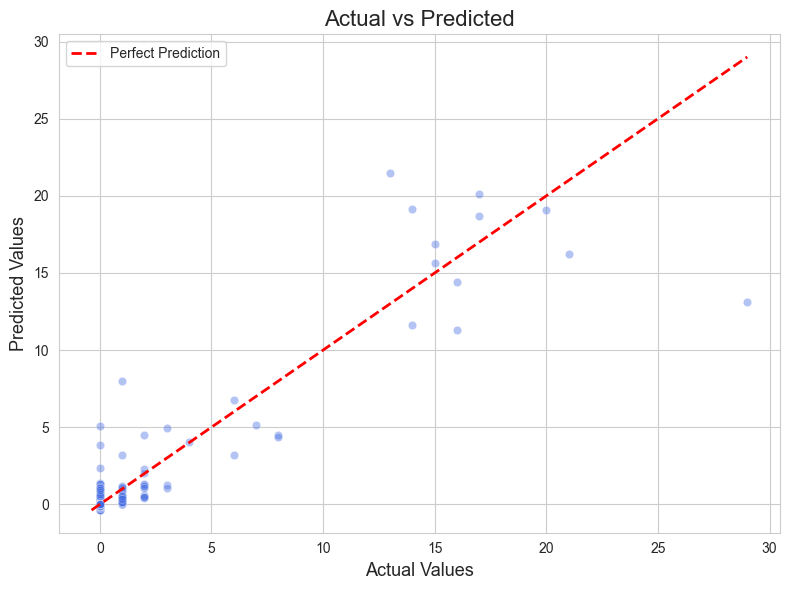

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ÏòàÏ∏° (Î°úÍ∑∏Í∞í)
y_pred_log = xgb_model.predict(X_test)
# Î°úÍ∑∏ Ïó≠Î≥ÄÌôò
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
results = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred
})
# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.scatterplot(
    x='Actual', y='Predicted', data=results,
    alpha=0.4, color='royalblue'
)
# ÏôÑÎ≤ΩÌïú ÏòàÏ∏°ÏÑ† (y = x)
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs Predicted', fontsize=16)
plt.xlabel('Actual Values', fontsize=13)
plt.ylabel('Predicted Values', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

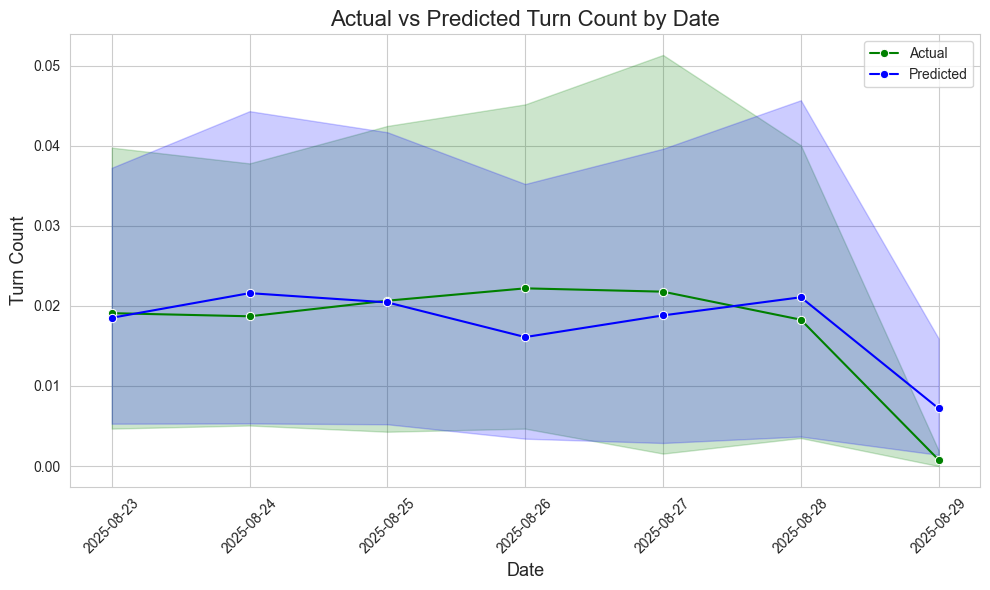

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# # Ïã§Ï†ú ÎÇ†Ïßú ÏÉùÏÑ±
# X_test['rpt_time_date'] = pd.to_datetime(X_test[['year','month','day']])

# # ÏòàÏ∏°Í∞í Ïó≠Î≥ÄÌôò (Î°úÍ∑∏ ÏòàÏ∏°Ïùº Í≤ΩÏö∞)
# y_pred = np.expm1(lgb_model.predict(X_test))
# y_true = np.expm1(y_test)  # Î°úÍ∑∏ Î≥ÄÌôòÎèº ÏûàÎã§Î©¥

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Ïã§Ï†ú Í∞í ÏÑ†
sns.lineplot(x=test_df['rpt_time_date'], y=y_test_exp, marker='o', color='green', label='Actual')

# ÏòàÏ∏° Í∞í ÏÑ†
sns.lineplot(x=test_df['rpt_time_date'], y=pred_test_exp, marker='o', color='blue', label='Predicted')

plt.title('Actual vs Predicted Turn Count by Date', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Turn Count', fontsize=13)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
test_check_df = test_df.copy()
test_check_df["y_true"] = y_test_exp
test_check_df["y_pred"] = pred_test_exp

In [ ]:
# test_check_df.to_csv("test_check_df.csv", index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


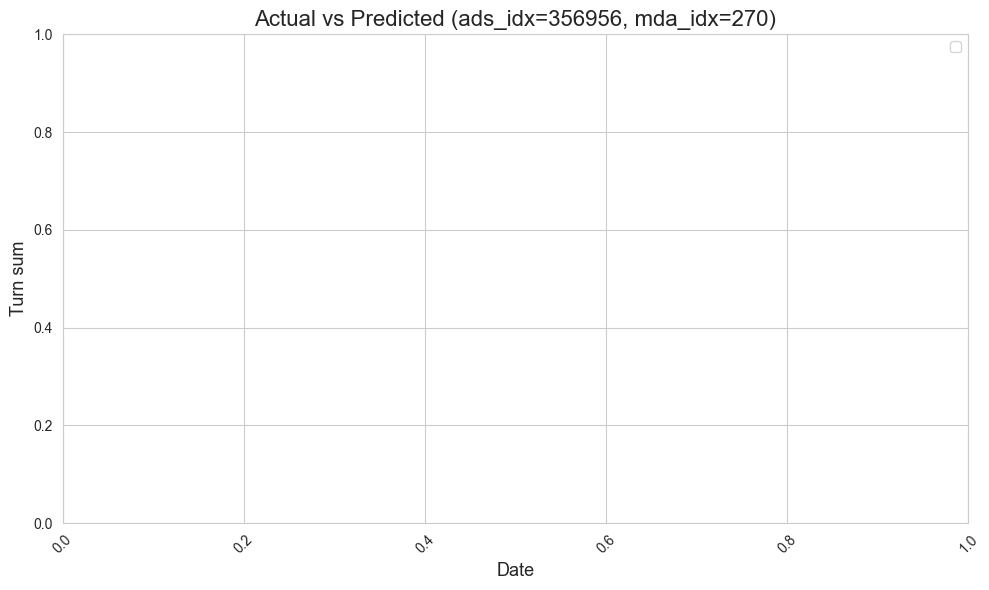

In [74]:
# ads_idx, mda_idx Ï°∞Í±¥ ÌïÑÌÑ∞ÎßÅ
cond_df = test_check_df[(test_check_df["ads_idx"] == 9982.0) & (test_check_df["mda_idx"] == 1047)]

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
sns.lineplot(x=cond_df['rpt_time_date'], y=cond_df['y_true'], marker='o', color='green', label='Actual')
sns.lineplot(x=cond_df['rpt_time_date'], y=cond_df['y_pred'], marker='o', color='blue', label='Predicted')

plt.title('Actual vs Predicted (ads_idx=356956, mda_idx=270)', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Turn sum', fontsize=13)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [1108]:
cond_df[['rpt_time_date', 'y_true', 'y_pred']]

rpt_time_date  y_true     y_pred
95474    2025-08-23    69.0  22.299391
95475    2025-08-24   209.0  33.813019
95476    2025-08-25   114.0  70.194542
95477    2025-08-26    48.0  56.330700
95478    2025-08-27    62.0  53.513992
95479    2025-08-28    19.0  38.404392
95480    2025-08-29    60.0  18.605728

In [1109]:
mix_df= test_check_df.groupby(['ads_idx', 'mda_idx']).apply(
    lambda x: np.abs(x['y_true'] - x['y_pred']).sum()
).reset_index(name='abs_error_sum').sort_values(by='abs_error_sum', ascending=False)

In [1110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# flag == 1Ïù∏ Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
df_flag = test_check_df[test_check_df["flag"] == 1]

# Ïã§Ï†úÍ∞íÍ≥º Î™®Îç∏ ÏòàÏ∏°Í∞í Ïª¨Îüº Ïù¥Î¶Ñ ÏòàÏãú
# (Ïù¥ÎØ∏ df ÏïàÏóê y_true, y_pred_A, y_pred_B Í∞ôÏùÄ Ïª¨ÎüºÏù¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï)
y_true = df_flag["y_true"].values
y_pred_A = df_flag["y_pred"].values   # Ï†ÑÏ≤¥ ÌïôÏäµ Î™®Îç∏

# ÏÑ±Îä•ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": f"{mae:.4f}", "RMSE": f"{rmse:.4f}", "R2": f"{r2:.4f}"}

# Îëê Î™®Îç∏ Í≤∞Í≥º ÎπÑÍµê
metrics_A = get_metrics(y_true, y_pred_A)

print("Î™®Îç∏ A (Ï†ÑÏ≤¥ ÌïôÏäµ, Í¥ëÍ≥†Ìïú ÎÇ† ÌèâÍ∞Ä):", metrics_A)
 

Î™®Îç∏ A (Ï†ÑÏ≤¥ ÌïôÏäµ, Í¥ëÍ≥†Ìïú ÎÇ† ÌèâÍ∞Ä): {'MAE': '4.2817', 'RMSE': '17.9089', 'R2': '0.7948'}


/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
/var/folders/hl/90p2p86n5cs6t3p_1xwxdx2r0000gn/T/ipykernel_50495/1982273722.py:30: UserWa

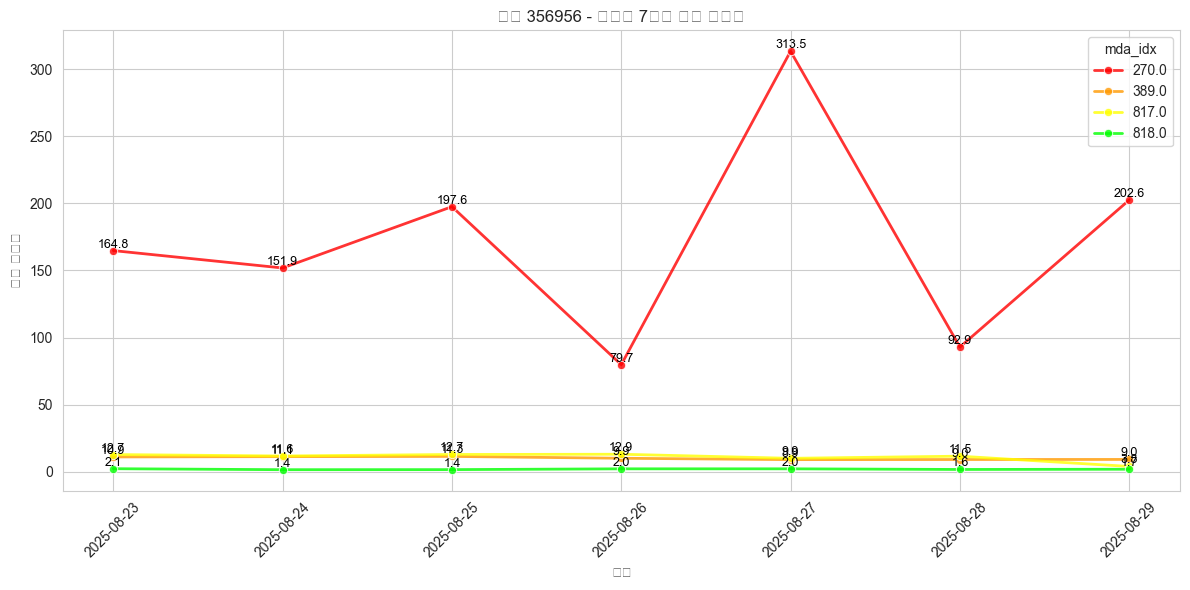

In [1111]:
import matplotlib.pyplot as plt
import seaborn as sns

target_ad = 356956
df_plot = df_flag[df_flag["ads_idx"] == target_ad].sort_values("rpt_time_date")

# Îπ®Ï£ºÎÖ∏Ï¥à Ïª¨Îü¨ Î¶¨Ïä§Ìä∏
color_list = ["#FF0000", "#FF9900", "#FFFF00", "#00FF00"]  # Îπ®Í∞ï, Ï£ºÌô©, ÎÖ∏Îûë, Ï¥àÎ°ù

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_plot,
    x="rpt_time_date",
    y="y_pred",
    hue="mda_idx",
    linewidth=2,
    alpha=0.8,
    marker="o",
    palette=color_list
)

for _, row in df_plot.iterrows():
    plt.text(row["rpt_time_date"], row["y_pred"], f'{row["y_pred"]:.1f}', 
             ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.title(f"Í¥ëÍ≥† {target_ad} - Îß§Ï≤¥Î≥Ñ 7ÏùºÍ∞Ñ ÏòàÏ∏° Ï†ÑÌôòÏàò")
plt.xlabel("ÎÇ†Ïßú")
plt.ylabel("ÏòàÏ∏° Ï†ÑÌôòÏàò")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
